# Prep runtime

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
!pip freeze

In [ ]:
### FOR RUNNING ON COLAB:
#update scikit-learn and imbalanced-learn to recent version
#!pip install sklearn-pandas-transformers
#!pip uninstall sklearn-pandas-transformers -y
#!pip uninstall sklearn_transformers_pandas -y

!pip uninstall scikit-learn -y
#!pip install -U scikit-learn==0.24.2 #specific version, because skopt does not work with sklearn 1.0.0 
!pip install -U scikit-learn==1.0.1

!pip uninstall imbalanced-learn -y
!pip install -U imbalanced-learn

!pip install scikit-optimize
!pip install scikit-plot

!pip install git+https://github.com/NUAA-AL/alipy.git

!pip install hmeasure
#!pip install git+https://github.com/jundongl/scikit-feature
!pip install git+https://github.com/lukekolbe/scikit-feature

#!pip install cvxpy

Found existing installation: scikit-learn 0.22.2.post1
Uninstalling scikit-learn-0.22.2.post1:
  Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 23.2 MB 1.9 MB/s 
Found existing installation: imbalanced-learn 0.4.3
Uninstalling imbalanced-learn-0.4.3:
  Successfully uninstalled imbalanced-learn-0.4.3
     |████████████████████████████████| 189 kB 6.4 MB/s 
     |████████████████████████████████| 100 kB 5.7 MB/s 
  Cloning https://github.com/NUAA-AL/alipy.git to /tmp/pip-req-build-9f1ze7ta
  Running command git clone -q https://github.com/NUAA-AL/alipy.git /tmp/pip-req-build-9f1ze7ta
  Created wheel for alipy: filename=alipy-1.2.5-py3-none-any.whl size=121053 sha256=de538e9730498aa537951cfe711db94b05006722bf2d3a949cccbc4460039119
  Stored in directory: /tmp/pip-ephem-wheel-cache-jz8k715e/wheels/e6/2f/a4/845ce9812f1a5c537c1bda39a26e36234a5a59535269feac13
Successfully built alipy
  Cloning https://github.com/lukekolbe/scikit-feature to /tmp/pip-r

In [ ]:
############ LIBRARIES

import os
import time
import datetime
import random
import multiprocessing
import pickle
import re
import copy
import gc
import sys
import json

gc.enable()

import warnings
warnings.filterwarnings('ignore')


import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
plt.style.use('default')
%matplotlib inline
import seaborn as sns

from itertools import cycle

import scikitplot as skplt

import scipy.stats
from sklearn.base import clone
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
#from sklearn.model_selection import StratifiedKFold  ##### what is this used for?
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix, roc_auc_score,roc_curve,average_precision_score, brier_score_loss, f1_score, fbeta_score, precision_score, recall_score
from sklearn.ensemble import IsolationForest

# FOR CROSS VALIDATED HYPERPARAMETER TUNING
# use imblearn pipeline instead of sklearn pipeline to skip AL sampling process in the prediction phase
from imblearn.pipeline import Pipeline
from imblearn import FunctionSampler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
#from skopt import BayesSearchCV #not compatible with latest sklearn, no option to use nested Parameter grid --> not applicable

from hmeasure import h_score

from skfeature.function.statistical_based.CFS import cfs
from skfeature.function.information_theoretical_based.FCBF import fcbf

from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression

#from alipy import ToolBox
from alipy import query_strategy
from alipy.index import IndexCollection
from alipy import data_manipulate

#from imblearn.under_sampling import RandomUnderSampler

In [ ]:
os.chdir('/gdrive/My Drive/ACTIVE LEARNING THESIS/')

In [ ]:
############ RANDOMNESS
# seed function
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    
# set seed
seed = 30
seed_everything(seed)

# Load Data

In [ ]:
############ DATA IMPORT

## available datasets
# bene1         # some learning
# bene1_nobins  # shape:  (3123, 18)
# bene2         # shape:  (7190, 28) #SOME LEARNING
# gmsc          # shape:  (150000, 68) y mean: 0.06 #DECENT LEARNING
# australian    # very small dataset shape:  (690, 42), y mean:  0.4449275362318841 #GOOD LEARNING
# german        # shape:  (1000, 61), y mean:  0.3 #SOME LEARNING
# hmeq          # shape:  (5960, 20), y mean:  0.199, #SOME LEARNING, VERY GOOD Calibration!
# uk            # shape:  (30000, 51), y mean:  0.04 # LITTLE learning

# thomas        # shape:  (1225, 28), y mean:  0.2636734693877551 #LITTLE LEARNING

# lendingclub   # loooow performance, X shape:  (41623, 114) y shape:  (41623,) y mean:  0.1331235134420873
# pakdd         # shape:  (50000, 373), y mean:  0.26082 #hardly any learning, likely too many features, too much noise. CFS does not work at all, removes useful features

dataset = "bene2"
# read CSV
#df = pd.read_csv('/Users/lukaskolbe/UNI/Master/Thesis/Active Learning/DATA/prepared_data/bene2.csv')
df = pd.read_csv('/gdrive/My Drive/ACTIVE LEARNING THESIS/prepared_data/{}.csv'.format(dataset))
#df = pd.read_csv('/gdrive/My Drive/ACTIVE LEARNING THESIS/prepared_data/bene2.csv')

# remove NA
df = df.dropna()
df.reset_index(drop = True, inplace = True)

#print(df)
# extract label
df['BAD'][df['BAD']=='BAD']  = 1
df['BAD'][df['BAD']=='GOOD'] = 0
df['BAD'] = df['BAD'].astype('int')

#print(df.head(5))

# Undersample majority class if mean of y is below threshold
'''do_undersample=False
frac = 0.7 #fraction to drop

if do_undersample and np.mean(df['BAD'])<0.2:
  print("y mean: ",np.mean(df['BAD']), f">> dropping {frac*100}% of bad cases \n")
  #RUS = RandomUnderSampler(sampling_strategy=0.25, random_state=seed, replacement=False)
  #df, y_temp = RUS.fit_resample(df, y_temp)
  drop_sample = df[df['BAD'] == 0].sample(frac=frac).index
  df.drop(drop_sample, inplace=True)  
  print(len(df))

else:
  do_undersample=False'''

y_temp = df['BAD']
del df['BAD']

# remove NA
#df = df.dropna()
#df.reset_index(drop = True, inplace = True)
#y_temp.reset_index(drop = True, inplace = True)
# print("df shape: ",df.shape)

#one hot encoding
df = pd.get_dummies(df)

#print(df.head(5))


#transform to numpy array >> same location for df and X
X = df.to_numpy()
y = y_temp.to_numpy()

#transform to numpy array >> different location for df and X
#X = df.to_numpy()
#y = y_temp.to_numpy()

#del(df, y_temp) # keep these because I only assinged a binding with X and y

## one hot encoding of factors
print("X type: ", type(X), "X shape: ",X.shape,"y shape: ", y.shape, "y mean: ", np.mean(y))
print (id(X), id(df))
#print(y)

X type:  <class 'numpy.ndarray'> X shape:  (7190, 28) y shape:  (7190,) y mean:  0.3
139620223051216 139620368814416


In [ ]:
# RUN THIS ONCE TO CREATE DIRECTORIES WHERE RESULTS ARE SAVED
'''from pathlib import Path
for dir in ['model_indices', 'model_cost', 'model_results']:
  for dat in ['bene1','bene1_nobins','bene2','gmsc','australian','german','thomas','hmeq','lendingclub','pakdd']:
    Path(f"{dir}/{dat}").mkdir(parents=True, exist_ok=True)'''

In [ ]:
'''sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=seed)
for model, validation in sss.split(X=X, y=y):
    model_idx, validation_idx = np.asarray(model), np.asarray(validation)    

print(np.sum(model_idx), np.sum(validation_idx)) #sanity check to compare with CV loop, make sure same data is used for validation and train
X_val, y_val = X[validation_idx,:], y[validation_idx]
X_model, y_model = X[model_idx,:], y[model_idx]
print(len(X_model), len(X), len(X_val)) # check if copies were made'''

20749760 5094695
5752 7190 1438


# Test classification run

In [ ]:
validation_size = 0.2

if len(X)*validation_size > 2000:
  validation_size = 2000

sss = StratifiedShuffleSplit(n_splits=1, test_size=validation_size, random_state=seed) # THESE ARE POSITIONS, NOT INDICES    
for model, validation in sss.split(X=X, y=y):
    model_idx, validation_idx = np.asarray(model), np.asarray(validation)    
scler = RobustScaler()
scler.fit(X[validation_idx])
#X_s = scler.transform(X)
X_s = X
'''#features = cfs(X_s[validation_idx, :], y[validation_idx])
features = fcbf(X_s[validation_idx, :], y[validation_idx])[0]
print('features',features)
print(np.shape(X_s))
X_s = X_s[:,features]
print(np.shape(X_s))'''
'''from sklearn.feature_selection import SelectPercentile, chi2
SP = SelectPercentile(percentile=20)
SP.fit(X_s[validation_idx,:], y[validation_idx])
X_s = SP.transform(X_s)
print(np.shape(X_s))'''


#X_s = np.array(X)
print(np.sum(model_idx), np.sum(validation_idx))
X_val, y_val = X_s[validation_idx,:], y[validation_idx]
X_model, y_model = X_s[model_idx,:], y[model_idx]
#print(id(X_model), id(X), id(X_val))
print(np.shape(X_model), np.shape(X_val))

20749760 5094695
(5752, 28) (1438, 28)


## analyser function

In [ ]:
'''def test_analyser(prediction=None, threshold = True):

    if threshold:
      # whole thresholding seems very clumsy
      # also: be careful not to confuse cutoff & threshold
      # cutoff is only for determining the share of cases that can be accepted (so as to not force a dumb model to accept bad instances)
      # why not use y_pred_with_threshold = (y_scores >= threshold).astype(int)

      cutoff = np.mean(y_model)
      print('cutoff', cutoff)
      quantile = np.quantile(prediction[:,1], 1 - cutoff)
      print('quantile', quantile)
      
      bad_pos = []
      #bad_pos = np.where((prediction[:,1] >= 1-quantile))
      bad_pos = np.where((prediction[:,1] >= quantile))
      #print('bad_pos', bad_pos[:15])
      
      y_pred_threshold = []
      y_pred_threshold = np.zeros(len(prediction[:,1]))
      y_pred_threshold[bad_pos] = 1
      pred = y_pred_threshold
    else:
      pred = np.rint(prediction[:,1]) #rint Round elements of the array to the nearest integer.
    
    ##########################################
    print('avg compare (y, pred (thres)): ', np.mean(y_model), np.mean(pred))
    print('prediction:', prediction[:25])
    print('pred (non)thresholded:', pred[:25])

    print('roc_auc',roc_auc_score(y_model, prediction[:,1])) #ROC AUC takes non-thresholded inputs
    print('brier',brier_score_loss(y_model, prediction[:,1]))
    print('h-measure',h_score(y_model, prediction[:,1]))

    print('f1',f1_score(y_model, pred))
    print('precision',precision_score(y_model, pred))
    print('recall',recall_score(y_model, pred))

    ecm = confusion_matrix(y_true=y_model, y_pred = pred) ##tn, fp, fn, tp
    print(ecm)
    tn, fp, fn, tp = ecm.ravel()
    print('fnr',fn/(fn+tp))
    print('fpr',fp/(tn+fp))
'''

## run that shit

median of prediction:  0.2585560842531385


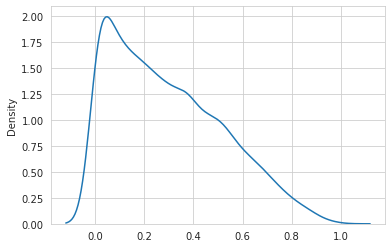

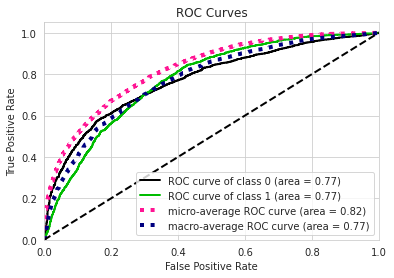

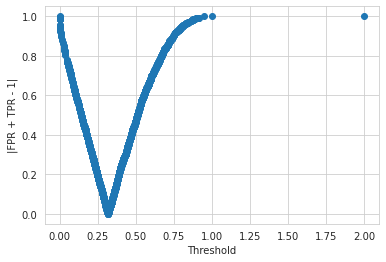

ROC minimum threshold: 0.3163128843805552 




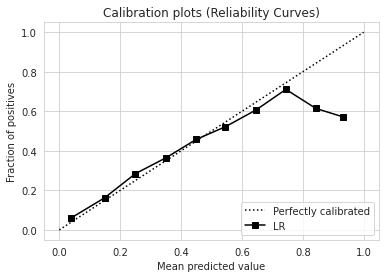

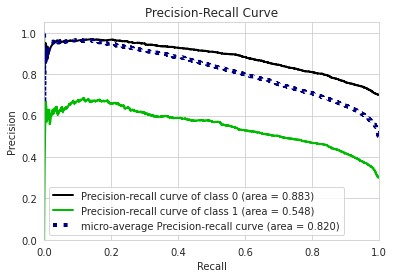

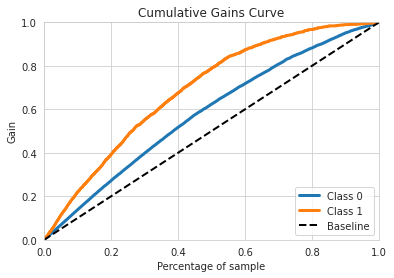

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import balanced_accuracy_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

#RUN TEST
#from sklearn.metrics import roc_curve

#model = LogisticRegression(solver="lbfgs", penalty = 'none', random_state=seed)
#model = LogisticRegression(solver="liblinear", penalty = 'l1', random_state=seed, class_weight='balanced')
model = LogisticRegression(solver="liblinear", penalty = 'l1', random_state=seed, class_weight=None)
#model = RandomForestClassifier(random_state=seed,class_weight='balanced')

#clf = CalibratedClassifierCV(base_estimator=model, cv=10)
clf = model

subsample = False

if subsample:
  sss = StratifiedShuffleSplit(n_splits=1, test_size=500, random_state=seed)
  for unlabel, label in sss.split(X=X_val, y=y_val):
    unlabel_idx, accept_idx = np.asarray(unlabel), np.asarray(label)   

else:
  accept_idx = np.arange(len(y_val))

clf.fit(X_val[accept_idx], y_val[accept_idx])
#clf.fit(X_val, y_val)
tpred = clf.predict_proba(X_model)
tprediction = clf.predict(X_model)
#print(np.shape(tprediction), np.shape(tpred))

##########################################
##########################################
##########################################

sns.set_style('whitegrid')
sns.kdeplot(x=tpred[:,1])
print("median of prediction: ", np.median(tpred[:,1]))

skplt.metrics.plot_roc_curve(y_model, tpred)
#https://scikit-plot.readthedocs.io/en/stable/metrics.html
plt.show()

fpr, tpr, thresholds = roc_curve(y_model,tpred[:,1],drop_intermediate=True)
threshold_pick=thresholds[np.argmin(np.abs(fpr+tpr-1))]

plt.scatter(thresholds,np.abs(fpr+tpr-1))
plt.xlabel("Threshold")
plt.ylabel("|FPR + TPR - 1|")
plt.show()
t#hreshold_pick=thresholds[np.argmin(np.abs(fpr+tpr-1))]
#which technique is this exactly?!
#https://www.yourdatateacher.com/2021/06/14/are-you-still-using-0-5-as-a-threshold/
#'It is equivalent to find the value of p for which the True Positive Rate is equal to the True Negative Rate (which is 1-FPR).'
print('ROC minimum threshold:',threshold_pick,'\n\n')
#print('Precision Recall minimum threshold:',thresholds_pr[np.argmin(np.abs(fpr+tpr-1))],'\n\n')

skplt.metrics.plot_calibration_curve(y_model,[tpred], ['LR'])
#https://scikit-plot.readthedocs.io/en/stable/metrics.html
#from sklearn.calibration import calibration_curve
#prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=5)

skplt.metrics.plot_precision_recall(y_model, tpred)
skplt.metrics.plot_cumulative_gain(y_model, tpred)

Best Threshold=0.277955, G-Mean=0.705


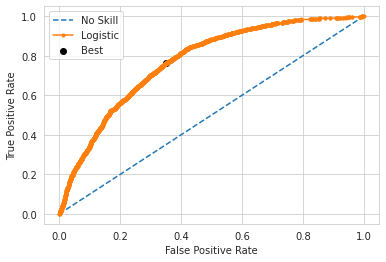

In [ ]:
# calculate the g-mean for each threshold
from numpy import sqrt
from numpy import argmax
from matplotlib import pyplot

#The Geometric Mean or G-Mean is a metric for imbalanced classification that, if optimized, will seek a balance between the sensitivity and the specificity.
#https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

fpr, tpr, thresholds = roc_curve(y_model, tpred[:,1])
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
gmean_threshold = thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (gmean_threshold, gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

avg compare (y, pred (thres), pred (no thres)):  0.30006954102920724 0.31641168289290683 0.5
true y:
 [0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0]
pred thresholded:
 [1 1 0 0 0 1 0 1 0 0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0]
pred non-thresholded:
 [0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0]

roc_auc 0.7710580099572938
brier 0.17233940169969794
h-measure 0.2458989428117655
average_precision_score 0.4171392623162615


NON-THRESHOLDED METRICS:
f1 0.4802744425385934
precision 0.5887300252312868
recall 0.4055619930475087
fnr:  0.5944380069524913
fpr:  0.12146050670640834
PCC:  0.7366133518776078
Balanced Acc:  0.6420507431705501


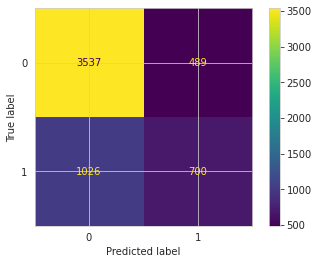

In [ ]:
##########################################
##########################################
##########################################

cutoff = threshold_pick
#cutoff = np.mean(y_model)
quantile = np.quantile(tpred[:,1], 1 - cutoff)

y_pred_threshold = (tpred[:,1] >= quantile).astype(int)  
#y_pred_threshold = (tpred[:,1] >= cutoff).astype(int)  

print('avg compare (y, pred (thres), pred (no thres)): ', np.mean(y_model), np.mean(y_pred_threshold), np.mean(tpred))
print('true y:\n', y_model[:25])
print('pred thresholded:\n', y_pred_threshold[:25])
print('pred non-thresholded:\n', tprediction[:25])

print('\nroc_auc',roc_auc_score(y_model, tpred[:,1])) #takes non-thresholded inputs, robust against class imbalance
print('brier',brier_score_loss(y_model, tpred[:,1]))#takes non-thresholded inputs, robust against class imbalance
print('h-measure',h_score(y_model, tpred[:,1]))#takes non-thresholded inputs, robust against class imbalance
print('average_precision_score',average_precision_score(y_model, tprediction))#takes non-thresholded inputs, robust against class imbalance
#print('KS-Statistic',scipy.stats.ks_2samp(X_model[y_pred_threshold==1], X_model[y_pred_threshold==0]).statistic)#takes non-thresholded inputs, robust against class imbalance

print('\n\nNON-THRESHOLDED METRICS:')

print('f1',f1_score(y_model, tprediction))
print('precision',precision_score(y_model, tprediction))
print('recall',recall_score(y_model, tprediction))

ecm = confusion_matrix(y_true=y_model, y_pred = tprediction) ##tn, fp, fn, tp
ConfusionMatrixDisplay.from_predictions(y_model, tprediction)

tn, fp, fn, tp = ecm.ravel()
print('fnr: ',fn/(fn+tp))
print('fpr: ',fp/(tn+fp))
print('PCC: ',(tp+tn)/(fp+fn+tp+tn))
print('Balanced Acc: ',balanced_accuracy_score(y_model, tprediction))





Y-MEAN-THRESHOLDED METRICS:
cutoff 0.2997218358831711
quantile 0.4093583088125924
f1 0.5507246376811594
precision 0.5510440835266821
recall 0.5504055619930475
fnr:  0.4495944380069525
fpr:  0.19225037257824143
PCC:  0.730528511821975
Balanced Acc:  0.679077594707403


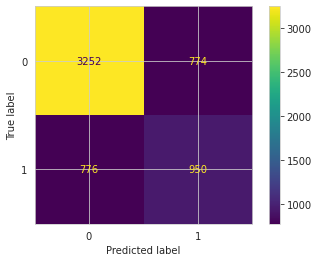

In [ ]:
print('\n\nY-MEAN-THRESHOLDED METRICS:')

cutoff = np.mean(y_val[accept_idx])
print('cutoff', cutoff)
quantile = np.quantile(tpred[:,1], 1 - cutoff)
#quantile=0.5
print('quantile', quantile)

y_pred_threshold_2 = (tpred[:,1] >= quantile).astype(int)  

print('f1',f1_score(y_model, y_pred_threshold_2))
#print('average_precision_score',average_precision_score(y_model, y_pred_threshold))
print('precision',precision_score(y_model, y_pred_threshold_2))
print('recall',recall_score(y_model, y_pred_threshold_2))

ecm = confusion_matrix(y_true=y_model, y_pred = y_pred_threshold_2) ##tn, fp, fn, tp
ConfusionMatrixDisplay.from_predictions(y_model, y_pred_threshold_2)

tn, fp, fn, tp = ecm.ravel()
print('fnr: ',fn/(fn+tp))
print('fpr: ',fp/(tn+fp))
print('PCC: ',(tp+tn)/(fp+fn+tp+tn))
print('Balanced Acc: ',balanced_accuracy_score(y_model, y_pred_threshold_2))


ROC-AUC TPR=TNR THRESHOLDED METRICS:

cutoff 0.3163128843805552
f1 0.5851654989127809
precision 0.5018648984666391
recall 0.7016222479721901
0.7014406358668653 = 0.7016222479721901
fnr:  0.29837775202781
fpr:  0.2985593641331346
PCC:  0.7014951321279554
Balanced Acc:  0.7015314419195278


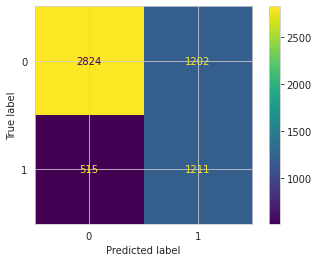

In [ ]:
print('ROC-AUC TPR=TNR THRESHOLDED METRICS:')

cutoff = threshold_pick
#cutoff = np.mean(y_model)
#quantile = np.quantile(tpred[:,1], 1 - cutoff)

#y_pred_threshold = (tpred[:,1] >= quantile).astype(int)  
y_pred_threshold = (tpred[:,1] >= cutoff).astype(int)  

print('\ncutoff', cutoff)
#print('quantile', quantile)

print('f1',f1_score(y_model, y_pred_threshold))
#print('average_precision_score',average_precision_score(y_model, y_pred_threshold))
print('precision',precision_score(y_model, y_pred_threshold))
print('recall',recall_score(y_model, y_pred_threshold))

ecm = confusion_matrix(y_true=y_model, y_pred = y_pred_threshold) ##tn, fp, fn, tp
ConfusionMatrixDisplay.from_predictions(y_model, y_pred_threshold)

tn, fp, fn, tp = ecm.ravel()
print((tn/(tn+fp)), '=', tp/(tp+fn))

print('fnr: ',fn/(fn+tp))
print('fpr: ',fp/(tn+fp))
print('PCC: ',(tp+tn)/(fp+fn+tp+tn))
print('Balanced Acc: ',balanced_accuracy_score(y_model, y_pred_threshold))


GMEANS THRESHOLDED METRICS:

cutoff 0.2779550280379516
f1 0.5920431557653405
precision 0.48365773044436283
recall 0.7630359212050984
fnr:  0.2369640787949015
fpr:  0.3492300049677099
PCC:  0.6844575799721836
Balanced Acc:  0.7069029581186943


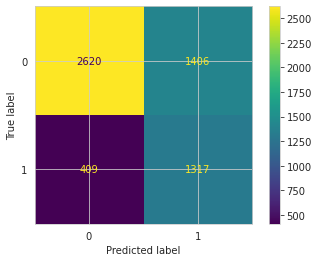

In [ ]:
print('GMEANS THRESHOLDED METRICS:')

cutoff = gmean_threshold
#cutoff = np.mean(y_model)
#quantile = np.quantile(tpred[:,1], 1 - cutoff)

#y_pred_threshold = (tpred[:,1] >= quantile).astype(int)  
y_pred_threshold = (tpred[:,1] >= cutoff).astype(int)  

print('\ncutoff', cutoff)
#print('quantile', quantile)

print('f1',f1_score(y_model, y_pred_threshold))
#print('average_precision_score',average_precision_score(y_model, y_pred_threshold))
print('precision',precision_score(y_model, y_pred_threshold))
print('recall',recall_score(y_model, y_pred_threshold))

ecm = confusion_matrix(y_true=y_model, y_pred = y_pred_threshold) ##tn, fp, fn, tp
ConfusionMatrixDisplay.from_predictions(y_model, y_pred_threshold)

tn, fp, fn, tp = ecm.ravel()
print('fnr: ',fn/(fn+tp))
print('fpr: ',fp/(tn+fp))
print('PCC: ',(tp+tn)/(fp+fn+tp+tn))
print('Balanced Acc: ',balanced_accuracy_score(y_model, y_pred_threshold))


CUSTOM THRESHOLDED METRICS:

cutoff 0.37
f1 0.5664093691775353
precision 0.5238798621368784
recall 0.6164542294322132
0.7598112270243418 = 0.6164542294322132
fnr:  0.38354577056778677
fpr:  0.24018877297565822
PCC:  0.7167941585535466
Balanced Acc:  0.6881327282282774


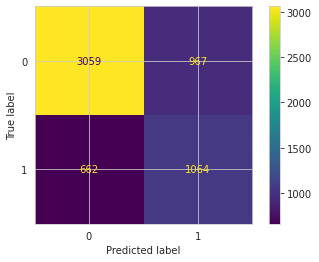

In [ ]:
print('CUSTOM THRESHOLDED METRICS:')

cutoff = 0.37
y_pred_threshold = (tpred[:,1] >= cutoff).astype(int)  

print('\ncutoff', cutoff)
#print('quantile', quantile)

print('f1',f1_score(y_model, y_pred_threshold))
print('precision',precision_score(y_model, y_pred_threshold))
print('recall',recall_score(y_model, y_pred_threshold))

ecm = confusion_matrix(y_true=y_model, y_pred = y_pred_threshold) ##tn, fp, fn, tp
ConfusionMatrixDisplay.from_predictions(y_model, y_pred_threshold)

tn, fp, fn, tp = ecm.ravel()
print((tn/(tn+fp)), '=', tp/(tp+fn))

print('fnr: ',fn/(fn+tp))
print('fpr: ',fp/(tn+fp))
print('PCC: ',(tp+tn)/(fp+fn+tp+tn))
print('Balanced Acc: ',balanced_accuracy_score(y_model, y_pred_threshold))


Youdens J THRESHOLDED METRICS:
Youdens J Best Threshold=0.101206

cutoff 0.10120559998707755
f1 0.5424121935056329
average_precision_score 0.37570239724419396
precision 0.37981438515081206
recall 0.9484356894553881
fnr:  0.051564310544611816
fpr:  0.6639344262295082
PCC:  0.5198191933240612
Balanced Acc:  0.6422506316129399


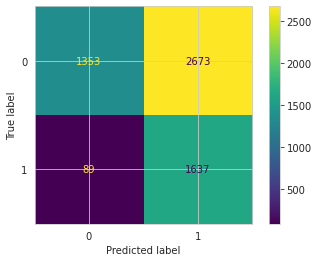

In [ ]:
print('Youdens J THRESHOLDED METRICS:')

J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Youdens J Best Threshold=%f' % (best_thresh))

cutoff = best_thresh
#cutoff = np.mean(y_model)
#quantile = np.quantile(tpred[:,1], 1 - cutoff)

#y_pred_threshold = (tpred[:,1] >= quantile).astype(int)  
y_pred_threshold = (tpred[:,1] >= cutoff).astype(int)  

print('\ncutoff', cutoff)
#print('quantile', quantile)

print('f1',f1_score(y_model, y_pred_threshold))
print('average_precision_score',average_precision_score(y_model, y_pred_threshold))
print('precision',precision_score(y_model, y_pred_threshold))
print('recall',recall_score(y_model, y_pred_threshold))

ecm = confusion_matrix(y_true=y_model, y_pred = y_pred_threshold) ##tn, fp, fn, tp
ConfusionMatrixDisplay.from_predictions(y_model, y_pred_threshold)

tn, fp, fn, tp = ecm.ravel()
print('fnr: ',fn/(fn+tp))
print('fpr: ',fp/(tn+fp))
print('PCC: ',(tp+tn)/(fp+fn+tp+tn))
print('Balanced Acc: ',balanced_accuracy_score(y_model, y_pred_threshold))


# Define (internal) cost function

In [ ]:
def internal_cost(y, accept_idx, reject_idx = None):

  # this function computes misclassification cost that accrues from selecting training data over the course of the experiment
  # each AL model will pick different instances to keep, so the accepted instances (i.e. credits) become increasingly different from another with each generation
  # Keeping an instance means they are effectively classified as  a "good risk (p=0), different misclassification cost for different algorightms is the result

  if reject_idx is not None: 
    index = np.concatenate((accept_idx, reject_idx)) # indices of all accepted and rejected cases used to subset y with

    #create vector of ones that has the same length as the index vector of all accepted and rejected cases combined
    #for all accepted cases, set this to zero, so that the cost performance can be computed via the confusion matrix
    prediction_scores = np.concatenate((np.zeros(len(accept_idx)), np.ones(len(reject_idx))))

  else:
    # first generation of any model will always land here, the oracle will always land here (no cases are ever rejected in the oracle)
    index = accept_idx
    prediction_scores = np.zeros(len(index))
 
  #compute internal confusion matrix, which is different than the one for test prediction
  confusion_mat = confusion_matrix(y[index], prediction_scores)
  print("internal tn, fp, fn, tp: ", confusion_mat.ravel())

  tn, fp, fn, tp = confusion_mat.ravel()

  fnr = fn/(fn+tp)
  fpr = fp/(fp+tn)

  print('internal fnr: ', fnr)
  print('internal fpr: ', fpr)
  
  # cost of 
  int_cost = [(fpr + (fnr * i)) for i in iter(np.linspace(2, 30, 29))]

  '''print(int_cost)
  print(type(int_cost))
  print(np.shape(int_cost))
  print('end of int cost calc')'''
  return int_cost, confusion_mat


# Define Helper Functions

In [ ]:
# get strategy

def strategy_getter(X, y, strategy_name="QueryInstanceRandom", train_idx = None, **kwargs):
    """Return the query strategy object from alipy package"""
    
    try:
        exec("from alipy.query_strategy import " + strategy_name)
    except:
        raise KeyError("Strategy " + strategy_name + " is not implemented in ALiPy.")
    strategy = None
    
    if train_idx is not None:
      strategy = eval(strategy_name + "(X=X, y=y, train_idx = train_idx, **kwargs)")
    else:
      strategy = eval(strategy_name + "(X=X, y=y, **kwargs)")
          
    # print(strategy)
    return strategy

## not used

In [ ]:
'''from sklearn.ensemble import IsolationForest

def outlier_rejection(X, y, **kwargs):
    """This will be our function used to resample our dataset."""
    model = IsolationForest(max_samples = 'auto', contamination='auto', random_state=seed, n_jobs = -1, **kwargs)
    model.fit(X)
    o_pred = model.predict(X)
    return X[o_pred == 1], y[o_pred == 1], o_pred #prediction is returned so labeled and unlabeled indices can be adjusted, too
'''

'from sklearn.ensemble import IsolationForest\n\ndef outlier_rejection(X, y, **kwargs):\n    """This will be our function used to resample our dataset."""\n    model = IsolationForest(max_samples = \'auto\', contamination=\'auto\', random_state=seed, n_jobs = -1, **kwargs)\n    model.fit(X)\n    o_pred = model.predict(X)\n    return X[o_pred == 1], y[o_pred == 1], o_pred #prediction is returned so labeled and unlabeled indices can be adjusted, too\n'

In [ ]:
 def prediction_analyser(prediction=prediction,stats=stats, gen=0, threshold = True, cutoff = np.mean(y[accept_idx])):

    ## set predictions according to threshold, then run through cost eval...
    # condidion returns true/false values, astype(int) coerces into 1/0
    ##########################################
    #### https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
    #### it needs to be a dynamic threshold such that a the number of cases classified as positive always mirrors the (actual) positive rate of the known data!
    #### this means that I cannot just set a fixed probability value!
    #### SOLVED: I now take the highest n predictions (for class 1), with n being the 1 - np.mean(y[accept_idx] quantile
    if threshold:
      bad_pos = np.where((prediction[:,1] >= np.quantile(prediction[:,1], 1 - cutoff)))
      y_pred_threshold = np.zeros(len(prediction))
      y_pred_threshold[bad_pos] = 1
      pred = y_pred_threshold
      #print('threshold vs pred: ', np.concatenate((y_pred_threshold[:100],pred[:,1][:100])))
      print('avg compare (y, pred_thres): ', np.mean(y[accept_idx.index]), np.mean(pred))
    else:
      pred = np.rint(prediction[:,1]) #rint rounds content of array to int
    
    ##########################################

    stats['bad_ratio_accepts'].loc[stats['generation'] == gen] = np.round(np.mean(y[accept_idx.index]), 4)
    stats['bad_ratio_rejects'].loc[stats['generation'] == gen] = np.round(np.mean(y[unlabel_idx.index]), 4)

    stats['roc_auc'].loc[stats['generation'] == gen] = roc_auc_score(y[test_idx], prediction[:,1]) #ROC AUC takes non-thresholded inputs
    
    stats['f1'].loc[stats['generation'] == gen] = f1_score(y[test_idx], pred)
    stats['precision'].loc[stats['generation'] == gen] = precision_score(y[test_idx], pred)
    stats['recall'].loc[stats['generation'] == gen] = recall_score(y[test_idx], pred)
    stats['brier'].loc[stats['generation'] == gen] = brier_score_loss(y[test_idx], pred)
    stats['h-measure'].loc[stats['generation'] == gen] = h_score(y[test_idx], pred)

    ext_confusion_mat = confusion_matrix(y_true=y[test_idx], y_pred = pred) ##tn, fp, fn, tp
    print(ext_confusion_mat)

    tn, fp, fn, tp = ext_confusion_mat.ravel()
    
    stats['tn'].loc[stats['generation'] == gen] = tn
    stats['fp'].loc[stats['generation'] == gen] = fp
    stats['fn'].loc[stats['generation'] == gen] = fn
    stats['tp'].loc[stats['generation'] == gen] = tp
    stats['fnr'].loc[stats['generation'] == gen]  = fn/(fn+tp)
    stats['fpr'].loc[stats['generation'] == gen]  = fp/(tn+fp)

    return stats, ext_confusion_mat

# Define AL Loop

In [ ]:
def AL_loop(data, y, indices, key,  AL_models, classifier=None, rounds=5, iteration=0, max_gens=10, sample_size=500, init_sample=1000, score_acc_rate=0.25, AL_acc_rate=0.25, seed=1, weights=False, w_factor=1, scale = True, do_threshold='mean', debug=False, tune_AL = True, class_balance=True, AL_params=None, CLF_params=None, cfs=False): #test_ratio = 0.3
  
  ##########################################
  # MISC LOOP SETUP
  ##########################################
  seed_everything(seed)
  
  ##############
  # use train-test indices via StratifiedKFold object passed as argument
  train_idx = indices[iteration][0]
  test_idx = indices[iteration][1]
  print('sanity check of train-test splits:',np.shape(train_idx), np.shape(test_idx))

  # ratio of initially labeled data
  init_ratio = np.round(init_sample/len(train_idx),6)
  #sss = StratifiedShuffleSplit(n_splits=1, test_size=init_ratio, random_state=seed)
  sss = StratifiedShuffleSplit(n_splits=1, test_size=init_sample, random_state=seed)
  for unlabel, label in sss.split(X=data[train_idx], y=y[train_idx]):
    unlabel_idx, accept_idx = np.asarray(unlabel), np.asarray(label)    

  unlabel_idx = IndexCollection(unlabel_idx)
  accept_idx = IndexCollection(accept_idx)

  #### APPLY ROBUST SCALER
  # scale once for each round (not each generation within the round) using the initial labeled set
  # in some cases this is a very small set to scale on...
  if scale:
    #scaler = MinMaxScaler()
    scaler = RobustScaler(with_centering=True, with_scaling=True)
    #scaler.fit(X[accept_idx[iteration], :])
    scaler.fit(data[accept_idx.index,:])
    X_t = scaler.transform(np.array(data)) #scaled version of full dataset
  
  else:
    X_t=np.array(data)

  # correlation-based feature selection
  # https://jundongl.github.io/scikit-feature/algorithms.html 
    '''if cfs:
    features = cfs(X_t[accept_idx[iteration], :], y[accept_idx[iteration]])
    #features = fcbf(X_t[accept_idx, :], y[accept_idx])
    print(features)
    print(np.shape(X_t))
    X_t = X_t[:,features[0]]
    print(np.shape(X_t))'''
  

  # calculate the actual number of generations that can be drawn from the data, in case max_gens * sample_size exceeds available training size
  #num_gens = int((np.min(len(train_idx), len(test_idx)) - init_sample) / sample_size)
  num_gens = int((len(train_idx) - init_sample) / sample_size)
  num_gens = np.min([num_gens, max_gens])
  print("strategy {}, round {}: running loop for {} generations".format(AL_models[key][0], iteration, num_gens))

  #initialize results dataframe
  stats = pd.DataFrame({'generation':    range(num_gens+1),
                    'bad_ratio_accepts': np.nan,
                    'bad_ratio_rejects': np.nan,
                    'roc_auc':           np.nan,
                    'brier':             np.nan,
                    'h-measure':         np.nan,
                    'average_precision': np.nan,
                    'balanced_accuracy': np.nan,
                    'n_accepts':         np.nan,
                    'n_rejects':         np.nan,
                    'n_score_accepts':   np.nan,
                    'n_AL_selects':      np.nan,
                    'bad_ratio_score_accepts': np.nan,
                    'bad_ratio_AL_selects': np.nan,

                    'precision':         np.nan,
                    'recall':            np.nan,
                    'f1':                np.nan, 
                    'fpr':               np.nan,
                    'fnr':               np.nan,

                    'tn':                np.nan,
                    'fp':                np.nan,
                    'fn':                np.nan,
                    'tp':                np.nan
                    #'time':             np.nan
                       })

  #cost dict
  cost = {'internal': [],
          'external': [],
          'total': []
          }

  # store indices that were drawn, needed mostly for debugging and plausibility checking
  indices = {'applicants_idx':    {},     # in each gen, new applicants are randomly drawn
              'gen_score_accept_idx':  {},    # top n accepted cases based on prediction score
              'gen_score_reject_idx':  {},    # rejected cases based on prediction score
              'gen_AL_select_idx':  {},   # this gen's AL selection
              
              'total_score_accept_idx': {},
              'total_AL_select_idx': {},  # all instances that were accepted via AL over all rounds
              'total_reject_idx':  {},    # 
              'accept_idx':        {},
              }
  

  ##########################################
  # SET INITIAL PERFORMANCE POINT WITH INITIAL SAMPLE
  ##########################################
  clf = clone(classifier, safe=True)
  clf.set_params(**CLF_params)
  if class_balance:
    clf.set_params(class_weight='balanced')
  print(str(clf))

  clf.fit(X=X_t[accept_idx.index,:], y=y[accept_idx.index]) ### first fit as basline, no AL selection was performed yet
  
  prediction = clf.predict_proba(X_t[test_idx, :])
  print('mean of initial prediction:', np.mean(prediction[:,1]))
  
  '''if debug:
    print('\n pred: ', prediction[:100])
    print("\n len initial pred:", np.shape(prediction), "\n")
    print("\n mean initial pred y=1:", np.mean(prediction[:,1]), "\n")
    sns.set_style('whitegrid')
    sns.kdeplot(prediction[:,1])
    plt.show()'''

  ##########################################
  # Calculate performance metrics for baseline
  ##########################################

  #define a function that does certain steps of analysis inside the loop, to be repeated at various stages of the loop
  def prediction_analyser(prediction=None,results=None, gen=0, do_threshold = True, threshold = np.mean(y[accept_idx.index])):

    ## set predictions according to threshold, then run through cost eval...
    # condidion returns true/false values, astype(int) coerces into 1/0
    ##########################################
    #### https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
    #### it needs to be a dynamic threshold such that a the number of cases classified as positive always mirrors the (actual) positive rate of the known data!
    #### this means that I cannot just set a fixed probability value!
    #### SOLVED: I now take the highest n predictions (for class 1), with n being the 1 - np.mean(y[accept_idx] quantile
    if do_threshold == 'mean':
      quantile = np.quantile(prediction[:,1], 1 - threshold)
      pred = (prediction[:,1] >= quantile).astype(int)
      print('avg compare (y, pred_thres): ', np.mean(y[accept_idx.index]), np.mean(pred))
      
    elif do_threshold == 'roc':
      fpr, tpr, thresholds = roc_curve(y[test_idx],prediction[:,1],drop_intermediate=True)
      threshold_pick=thresholds[np.argmin(np.abs(fpr+tpr-1))]
      pred = (prediction[:,1] >= threshold_pick).astype(int)
      print('avg compare (y, pred_thres): ', np.mean(y[accept_idx.index]), np.mean(pred))
    
    else:
      pred = np.rint(prediction[:,1]) #rint Round elements of the array to the nearest integer.
    
    ##########################################

    results['roc_auc'].loc[results['generation'] == gen] = roc_auc_score(y[test_idx], prediction[:,1]) #ROC AUC takes non-thresholded inputs
    results['brier'].loc[results['generation'] == gen] = brier_score_loss(y[test_idx], prediction[:,1])
    results['h-measure'].loc[results['generation'] == gen] = h_score(y[test_idx], prediction[:,1])
    results['average_precision'].loc[results['generation'] == gen] = average_precision_score(y[test_idx], prediction[:,1])
    
    results['f1'].loc[results['generation'] == gen] = f1_score(y[test_idx], pred)
    results['precision'].loc[results['generation'] == gen] = precision_score(y[test_idx], pred)
    results['recall'].loc[results['generation'] == gen] = recall_score(y[test_idx], pred)
    results['balanced_accuracy'].loc[results['generation'] == gen] = balanced_accuracy_score(y[test_idx], pred)

    ecm = confusion_matrix(y_true=y[test_idx], y_pred = pred) ##tn, fp, fn, tp
    print(ecm)

    tn, fp, fn, tp = ecm.ravel()
    
    results['tn'].loc[results['generation'] == gen] = tn
    results['fp'].loc[results['generation'] == gen] = fp
    results['fn'].loc[results['generation'] == gen] = fn
    results['tp'].loc[results['generation'] == gen] = tp
    results['fnr'].loc[results['generation'] == gen]  = fn/(fn+tp)
    results['fpr'].loc[results['generation'] == gen]  = fp/(tn+fp)

    return results, ecm


  # SET CUTOFF ONCE FOR WHOLE ROUND, BASED ON THE MEAN OF Y[ACCEPT_IDX] FROM ROUND 0
  # CUTOFF IS NOT ADJUSTED, SINCE ANY NON-RANDOM SELECTION METHOD BIASES THE DATA
  cutoff = np.round(np.mean(y[accept_idx])*1.1, 3)
  print('BAD ratio:', np.mean(y[accept_idx]), 'CUTOFF:', cutoff)
                        
  # run the analyser function.
  stats, ext_confusion_mat = prediction_analyser(prediction, stats, gen=0, do_threshold=do_threshold)

  tn, fp, fn, tp = ext_confusion_mat.ravel()
  fnr = fn/(fn+tp)
  fpr = fp/(tn+fp)

  # save indices and bad ratios of initial round
  indices['accept_idx'][0] = accept_idx.index  #store initially accepted indices
  stats['bad_ratio_accepts'].loc[stats['generation'] == 0] = np.round(np.mean(y[accept_idx.index]), 4)
  stats['bad_ratio_rejects'].loc[stats['generation'] == 0] = np.round(np.mean(y[unlabel_idx.index]), 4)

  ########## COMPUTE COST ############
  '''cost['internal'].append(internal_cost(y, accept_idx.index)) # for first round, there are no rejects yet, so only accepts are provided. This goes regardless of AL model.
  #print('int cost: ', cost['internal'])
  #print(np.shape(cost['internal']))

  
  cost['external'].append([fpr + fnr * i for i in iter(np.linspace(2, 30, 29))])
  #print('ext cost: ', cost['external'])
  #print(np.shape(cost['external']))

  # total cost is the sum of internal and external cost weighted by the number of instances the cost was calculated on
  total_len = len(accept_idx.index) + len(test_idx)  # number of instances used for internal and external cost
  cost['total'].append([internal + external for internal, external in zip([i * (len(accept_idx.index) / total_len) for i in cost['internal'][0]], [e * (len(test_idx) / total_len)  for e in cost['external'][0]])]) 

  #cost['total'].append(cost['internal'][0] * (len(accept_idx.index) / total_len_0) + 
  #                     cost['external'][0] * (len(test_idx) / total_len_0)
                       
  '''

  ########################################################################
  # LOAD AL Strategies
  ########################################################################

  #name = AL_models[key][1]
  if key in ["random", "unc", "qbc", "eer", "dw", "bmdr", "spal"]:
    strategy = strategy_getter(X_t, y, **AL_params) #, **, al_hyperparameters

  elif key == "lal":
    if tune_AL:
      reg_est = AL_params['reg_est']
      reg_depth = AL_params['reg_depth']
      reg_feat = AL_params['reg_feat']
      cls_est = AL_params['cls_est']
    else:
      reg_est = 64
      reg_depth = 5
      reg_feat = 6
      cls_est= 32

    strategy = strategy_getter(X_t, y, mode='LAL_iterative', train_slt=False, cls_est = cls_est) #**param_dict
    strategy.download_data()
    strategy.train_selector_from_file(reg_est=reg_est, reg_depth=reg_depth, feat=reg_feat)
  
  elif key in ["cors", "density", "quire"]:
    # these AL models need actual training indices and must hence be initialized in every generation of the loop, using the newest applicants and accepts from former generations
    pass


  # timer
  loop_start = time.time()
  
  ########################################################################
  # ACCEPTANCE LOOP with AL
  ########################################################################
  for g in range(num_gens):

    seed_everything(seed)
    
    ##########################################
    # DRAW APPLICANTS IN EACH GENERATION
    # we draw a stratified sample from the unlabeled indices to avoid samples without minority class instances
    # break condition prior to meeting num_gens when not enough unlabeled instances to draw a full sample containing both classes
    # this is done because StratifiedShuffleSplit works with float test sizes
    ##########################################

    if sample_size < len(unlabel_idx.index) and 1 > np.mean(y[unlabel_idx.index]) > 0:
      sss = StratifiedShuffleSplit(n_splits=1, test_size=sample_size, random_state=seed) # THESE ARE POSITIONS, NOT INDICES
      
      for dump_idx, use_idx in sss.split(X=np.zeros(len(unlabel_idx.index)), y=y[unlabel_idx.index]): #just splitting on y, hence X provided as zeros
        sss_applicants_pos = np.asarray(use_idx) #Yields positions of applicants in UNLABEL INDEX
        #sss_unlabel_pos, sss_applicants_pos = np.asarray(dump_idx), np.asarray(use_idx)
      
      applicants_idx = np.asarray(unlabel_idx.index)[sss_applicants_pos]
      applicants_idx = IndexCollection(applicants_idx)
      unlabel_idx.difference_update(applicants_idx) # delete applicants_idx from unlabel_idx
    
    else:
      break #break loop if not enough instances are left or only instances of one class remain
    
    if debug:
      print("\n len applicants_idx:", len(applicants_idx.index), "\n")

    #add applicants to indices dictionary
    #should be the same for every strategy & round >> just a plausibility check
    indices['applicants_idx'][g+1] = applicants_idx.index 

    ##########################################
    # SELECT AND SCORE APPLICANTS
    ##########################################
    
    # accept all applicants for "oracle" model
    if key == 'oracle':
      accept_idx.update(applicants_idx)

      indices['accept_idx'][g+1] = accept_idx.index #save 0-state of accept_idx (same for all rounds) 
      
      #save bad ratios of oracle
      stats['bad_ratio_accepts'].loc[stats['generation'] == g+1] = np.round(np.mean(y[accept_idx.index]), 4)
      stats['bad_ratio_rejects'].loc[stats['generation'] == g+1] = np.round(np.mean(y[unlabel_idx.index]), 4) # not very accurate, since there are no rejects technically
    
    else:
      ## PREDICTION ON APPLICANTS
      applicants_pred = clf.predict_proba(X_t[applicants_idx.index, :])
      
      '''if key == 'score':
        ### this strategy accepts the same overall number of instances as AL strategies, but merely based on the score >> it is "dumb"
        accept_rate = score_acc_rate+AL_acc_rate

      else:
        accept_rate = score_acc_rate'''

      #cutoff is computed in line ~180, using only the initial sample
      #consists of the mean value of y[accept_idx] times 1.1 >> this gives some leeway/buffer
      # THIS IS NOT THE THRESHOLD FOR PREDICTIONS, serves different purpose
      #used to make sure that the SCORE-only model is not forced to accept MORE samples than are expected to be GOOD
      #this could happen if the score accept rate is set to 0.5 and the AL accept rate to 0.25, meaning a total of 75% of applicants are accepted
        #remember: in order to accept the same number of instances in all models, the score model adds AL accept rate and score accept rate together 
        #if the good ratio of the data is only 0.7, then the score model would 'knowingly' have to accept a certain number of bad instances
        #this is avoided by using the cutoff
      accept_cutoff = np.round(((1 - cutoff) * accept_rate),3) # e.g. cutoff at 0.3 (30% BAD expected in the data), accept rate = 0.75 >> cutoff at (1 - 0.3) * 0.75 = 0.525

      score_accept_pos = np.where(applicants_pred[:,0] >= np.quantile(applicants_pred[:, 0], 1 - accept_cutoff)) # gives positions (indices of indices) where condition applies
      gen_score_accept_idx = np.asarray(applicants_idx.index)[score_accept_pos] # get actual indices based on positions
      gen_score_accept_idx = IndexCollection(gen_score_accept_idx)
      accept_idx.update(gen_score_accept_idx) # add top ranking applicants to overall accepted cases


      '''if debug:
        print("score accept pos: ", score_accept_pos)
        print("score accept idx: ", gen_score_accept_idx)
        print("\n len gen_score_accept_idx:", len(gen_score_accept_idx.index), "\n")'''

      score_reject_pos = np.where(applicants_pred[:,0] < np.quantile(applicants_pred[:, 0], 1 - accept_cutoff))
      gen_score_reject_idx = np.asarray(applicants_idx.index)[score_reject_pos]
      gen_score_reject_idx = IndexCollection(gen_score_reject_idx)
      
      if debug:
        print("\n len gen_score_reject_idx:", len(gen_score_reject_idx.index), "\n")
      
      indices['gen_score_accept_idx'][g+1] = gen_score_accept_idx.index 
      indices['gen_score_reject_idx'][g+1] = gen_score_reject_idx.index

    ####################################################################################
    # 2nd STEP: PERFORM AL-SELECTION OF APPLICANTS
    ####################################################################################

    if key not in ['oracle', 'score']:

      ##########################################
      # 2nd STEP: PERFORM AL-SELECTION OF APPLICANTS
      # SETUP
      ##########################################

      # calculate AL-quota with cutoff
      # as before, the cutoff is used to make sure that the score model is not forced to select bad instances
      # it is also applied to the AL accept rate in order to keep the ratios of AL and SCORE accepted cases constant
      AL_accept_cutoff = np.round(((1 - cutoff) * AL_acc_rate),3)
      n_instances = int(sample_size*AL_accept_cutoff)
      print('no. of AL-accepted instances:', n_instances)
      
      # re-initialize strategies that take train_idx as argument, as indexes chang each round
      '''if hasattr(strategy, "_train_idx") or hasattr(strategy, "train_idx"):
          al_idx=np.concatenate((np.asarray(accept_idx.index), np.asarray(gen_score_reject_idx.index)))
          strategy.__init__(X_t, y, train_idx=al_idx) #, **al_hyperparameters'''

      if key in ["cors", "density", "quire"]:
        al_idx=np.concatenate((np.asarray(accept_idx.index), np.asarray(gen_score_reject_idx.index)))
        strategy = strategy_getter(X_t, y, train_idx=al_idx, **AL_params)#, **al_hyperparameters

      ##########################################
      # MAKE SELECTION
      ##########################################
      ## quire has no batch mode, instances are selected one by one >> so a loop is needed
      if key == 'quire':
        gen_AL_select_idx = np.zeros(shape=n_instances, dtype=int) #empty array to be filled with selected indices
        for n in range(n_instances):
          gen_AL_select_idx[n] = strategy.select(label_index=accept_idx, unlabel_index=gen_score_reject_idx)[0] # returns a list of len one, hence the [0]
          accept_idx.update(gen_AL_select_idx[n])
          gen_score_reject_idx.difference_update(gen_AL_select_idx[n])
        gen_AL_select_idx = IndexCollection(gen_AL_select_idx)

      else:
        # select instances for this gen and AL Model
        gen_AL_select_idx = strategy.select(label_index=accept_idx, unlabel_index=gen_score_reject_idx, batch_size=n_instances, model=clf) 
        gen_AL_select_idx = IndexCollection(gen_AL_select_idx)
      
      if debug:
        print("\n len gen_AL_select_idx:", len(gen_AL_select_idx.index), "\n")
      
      indices['gen_AL_select_idx'][g+1] = gen_AL_select_idx.index #Different for every model

      ## add score and AL selected instances to accept_idx
      accept_idx.update(gen_score_accept_idx)
      accept_idx.update(gen_AL_select_idx)

      ## remove AL selects from (score) rejected cases
      gen_score_reject_idx.difference_update(gen_AL_select_idx)
      '''if debug:
        print("len gen_score_reject_idx: ", len(gen_score_reject_idx.index))
        print("TYPES gen_score_reject_idx list and index: ", type(gen_score_reject_idx), type(gen_score_reject_idx.index[0]))
        print(type(gen_score_reject_idx.index[0]))
        print(type(gen_AL_select_idx.index[0]))'''


    ####################################################################################
    # Save rejected and accepted cases
    ####################################################################################
    
    # same for score and AL-models
    indices['accept_idx'][g+1] = accept_idx.index
    stats['bad_ratio_accepts'].loc[stats['generation'] == g+1] = np.round(np.mean(y[accept_idx.index]), 4)

    if key != 'oracle':
      
      if g == 0:
        total_score_accept_idx = IndexCollection(np.asarray(gen_score_accept_idx.index))
        total_reject_idx = IndexCollection(np.asarray(gen_score_reject_idx.index)) # define total reject index list in initial generation, update after
        
      else:
        total_score_accept_idx.update(gen_score_accept_idx)
        total_reject_idx.update(gen_score_reject_idx)
        
      if key != 'score':
        # for all AL Models
        if g==0:
          total_AL_select_idx = IndexCollection(np.asarray(gen_AL_select_idx.index))
        else:
          total_AL_select_idx.update(gen_AL_select_idx)

        indices['total_AL_select_idx'][g+1] = total_AL_select_idx.index #Different for every model
        stats['n_AL_selects'].loc[stats['generation'] == g+1] = len(total_AL_select_idx.index)
        stats['bad_ratio_AL_selects'][g+1] = np.round(np.mean(y[total_AL_select_idx.index]), 4) # different to some degree

      indices['total_reject_idx'][g+1] = total_reject_idx.index # different to some degree
      indices['total_score_accept_idx'][g+1] = total_score_accept_idx.index # different to some degree
      
      stats['bad_ratio_rejects'].loc[stats['generation'] == g+1] = np.round(np.mean(y[total_reject_idx.index]), 4)
      stats['n_accepts'].loc[stats['generation'] == g+1] = len(accept_idx.index)
      stats['n_rejects'].loc[stats['generation'] == g+1] = len(total_reject_idx.index)
      stats['n_score_accepts'].loc[stats['generation'] == g+1] = len(total_score_accept_idx.index)      
      stats['bad_ratio_score_accepts'][g+1] = np.round(np.mean(y[total_score_accept_idx.index]), 4) # different to some degree

      if debug:
        print(type(total_reject_idx.index))
        print(type(total_AL_select_idx.index))
        print("\n len total_AL_select_idx: ", len(total_AL_select_idx.index), "\n")


    ##########################################
    # PREDICTION TEST SCORING OF SELECTED INSTANCES, GATHER PERFORMANCE METRICS
    ##########################################

    if weights and key not in ['oracle', 'score']:
      # use sample weights in fitting
      ### not too efficient to save "total_AL_select_idx" and re-initialize sample_weights every gen... A smarter solution would just add correct weights dynamically

      #find matches in AL select and accept indices and set weights for these rows
      sample_weights=np.ones(len(accept_idx.index))
      sample_weights[np.where(np.in1d(accept_idx.index, total_AL_select_idx.index, assume_unique=True, invert=False))] = w_factor 
      
      '''if debug:
        print("len accept_idx: ", len(accept_idx.index), "\n", 
            "len total AL accepts: ", len(total_AL_select_idx.index), "\n", 
            "sum of weighted instances: ", sum(1 for i in sample_weights if i / w_factor != 0), "\n", 
            "mean of weights: ",np.mean(sample_weights))
        print(pd.DataFrame(total_AL_select_idx))
        print(pd.DataFrame(data={"index": accept_idx.index,'weights': sample_weights, 'class': y[accept_idx.index]}))'''
        
      clf.fit(X=X_t[accept_idx.index, :], y=y[accept_idx.index], sample_weight=sample_weights) ### IMPLEMENT IF WEIGHTS CONDITION
    
    else:
      # fit clf again with all selected instances
      clf.fit(X=X_t[accept_idx.index, :], y=y[accept_idx.index]) 
    
    ##########################################
    # predict on TEST
    ##########################################
    prediction = clf.predict_proba(X_t[test_idx, :])
    print(f'mean of gen {g} prediction:', np.mean(prediction[:,1]))

    ### COMPUTE & COLLECT Test prediction performance for this generation
    stats,ext_confusion_mat = prediction_analyser(prediction, stats, gen=g+1, do_threshold=do_threshold)
    #print('test from prediction_analyser)', stats['tn'].loc[stats['generation'] == g+1])

    tn, fp, fn, tp = ext_confusion_mat.ravel()
    fnr = fn/(fn+tp)
    fpr = fp/(tn+fp)

    ########## COMPUTE COST ############
    #cost['internal'].append(internal_cost(y, accept_idx.index, total_reject_idx.index))

    if key != 'oracle':
      int_cost, int_confusion_mat = internal_cost(y, accept_idx.index, reject_idx = total_reject_idx.index)
      cost['internal'].append(int_cost)
      internal_len = len(accept_idx.index) + len(total_reject_idx.index)
      total_len = internal_len + len(test_idx)  # total number of instances used for internal and external cost >> prep for total cost calculation

    else:
      int_cost, int_confusion_mat = internal_cost(y, accept_idx.index)      
      cost['internal'].append(int_cost)
      internal_len = len(accept_idx.index)
      total_len = internal_len + len(test_idx)  # total number of instances used for internal and external cost >> oracle is different, because it has no rejects

    cost['external'].append([fpr + fnr * i for i in iter(np.linspace(2, 30, 29))])

    #print("internal cost: \n",cost['internal'])
    #print("\n external cost: \n",cost['external'])

    #######
    #total cost
    total_confusion_mat = int_confusion_mat + ext_confusion_mat
    tn_tot, fp_tot, fn_tot, tp_tot = total_confusion_mat.ravel()
    print("tn_tot, fp_tot, fn_tot, tp_tot: ",total_confusion_mat.ravel())

    cost['total'].append([(fp_tot/(tn_tot+fp_tot)) + (fn_tot/(fn_tot+tp_tot)) * i for i in iter(np.linspace(2, 30, 29))])


    # total cost is the sum of internal and external cost weighted by the share of instances the cost was calculated on
    # two inner list comprehensions compute the weight for external and internal cost (as per the number of samples used); 
    # outer list comprehension does element-wise addition of those weighted costs
    #cost['total'].append([internal + external for internal, external in zip([i * (internal_len / total_len) for i in cost['internal'][g]], 
    #                                                                        [e * (len(test_idx) / total_len)  for e in cost['external'][g]])]) 


    ################################################################################################################
    # display some info at the end of every second round
    ################################################################################################################

    if (g % 2 == 0):
      if key == "oracle":
        print(f'gen {g}/{num_gens} | # applicants = {len(applicants_idx.index)} | score accepts = NaN | AL selects = NaN | total accepts = {len(accept_idx.index)} | unlabelled = {len(unlabel_idx.index)} |  time = {((time.time() - loop_start) / 60):.2f} min')
      elif key == 'score':
        print(f'gen {g}/{num_gens} | # applicants = {len(applicants_idx.index)} | score accepts = {len(gen_score_accept_idx.index)} | AL selects = NaN | total accepts = {len(accept_idx.index)} | unlabelled = {len(unlabel_idx.index)} |  time = {((time.time() - loop_start) / 60):.2f} min')
      else:
        print(f'gen {g}/{num_gens} | # applicants = {len(applicants_idx.index)} | score accepts = {len(gen_score_accept_idx.index)} | AL selects = {len(gen_AL_select_idx.index)} | total accepts = {len(accept_idx.index)} | unlabelled = {len(unlabel_idx.index)} |  time = {((time.time() - loop_start) / 60):.2f} min')
        #AL = {len(total_AL_select_idx.index)} | total rejects = {len(total_reject_idx.index)} |
        #.format(g, num_gens, len(applicants_idx.index), len(accept_idx), len(unlabel_idx), (time.time() - loop_start) / 60))  # strategy{} >> re.search('query_labels.(.+?)\'>', str(strategy.__class__)).group(1)
        
  print('\n Finished {} generations in {:.2f} minutes'.format(num_gens, (time.time() - loop_start) / 60), '\n \n \n -------------------------------------------------')

  return stats, indices, cost

In [ ]:
ymean=0.3
cutoff = ymean*1.1
print(np.round(cutoff, 3))

accept_cutoff = np.round(((1 - cutoff) * 0.75),3)
print(quantile)


0.33
0.502


In [ ]:
'''int_c = np.random.randint(5, size=(30))
ext_c = np.random.randint(5, size=(30))
tot_c = []

#two inner list comprehensions compute the weight for external and internal cost (as per the number of samples used); 
#outer list comprehension does element-wise addition of those weighted costs
tot_c.append([a + b for a, b in zip([i * (3 / 33) for i in int_c], [j * (30 / 33)  for j in ext_c])]) 


#tot_c.append(np.array([i * (3 / 33) for i in int_c]) + [j * (30 / 33)  for j in ext_c])

print(ext_c)
print(int_c)
print([i * (3 / 33) for i in int_c])
print([j * (30 / 33)  for j in ext_c])

print(tot_c[0])
'''

'int_c = np.random.randint(5, size=(30))\next_c = np.random.randint(5, size=(30))\ntot_c = []\n\n#two inner list comprehensions compute the weight for external and internal cost (as per the number of samples used); \n#outer list comprehension does element-wise addition of those weighted costs\ntot_c.append([a + b for a, b in zip([i * (3 / 33) for i in int_c], [j * (30 / 33)  for j in ext_c])]) \n\n\n#tot_c.append(np.array([i * (3 / 33) for i in int_c]) + [j * (30 / 33)  for j in ext_c])\n\nprint(ext_c)\nprint(int_c)\nprint([i * (3 / 33) for i in int_c])\nprint([j * (30 / 33)  for j in ext_c])\n\nprint(tot_c[0])\n'

# Define plotting function

In [ ]:
def stats_plotter(stats, cost=None):  # plot size
  fig = plt.figure(figsize = (30, 30))

  plt.subplot(7, 2, 1)
  color=iter(cm.rainbow(np.linspace(0,1,len(stats))))
  lines = cycle(["-","--","-.",":"])
  for key in stats.keys():
    c=next(color)
    l=next(lines)
    # absoute values
    plt.plot(stats["{}".format(key)]['average']['roc_auc'], c=c, ls=l, label = AL_models[key][0],  linewidth = 2)
    plt.xlabel('Generation', fontsize = 15)
    plt.ylabel('ROC AUC score',        fontsize = 15)
    #plt.legend(prop = {'size': 12}, bbox_to_anchor=(1, 1), loc='upper left')
    plt.legend(prop = {'size': 12}, loc='upper center', bbox_to_anchor=(0.7, 0.4),
          fancybox=True, shadow=True, ncol=3)

  plt.subplot(7, 2, 2)
  color=iter(cm.rainbow(np.linspace(0,1,len(stats))))
  lines = cycle(["-","--","-.",":"])
  for key in stats.keys():
    c=next(color)
    l=next(lines)
    # absoute values
    plt.plot(stats["{}".format(key)]['average']['h-measure'], c=c, ls=l, label = AL_models[key][0],  linewidth = 2)
    #plt.xlabel('Generation', fontsize = 15)
    plt.ylabel('h-measure',        fontsize = 15)
    #plt.legend(prop = {'size': 12}, bbox_to_anchor=(1, 1), loc='upper left')

  # Brier-score
  plt.subplot(7, 2, 3)
  color=iter(cm.rainbow(np.linspace(0,1,len(stats)))) 
  lines = cycle(["-","--","-.",":"])
  for key in stats.keys():
    c=next(color)
    l=next(lines)
    # absoute values
    plt.plot(stats["{}".format(key)]['average']['brier'], c=c, ls=l, label = AL_models[key][0],  linewidth = 2)
    #plt.xlabel('Generation', fontsize = 15)
    plt.ylabel('Brier score',        fontsize = 15)
    #plt.legend(prop = {'size': 12}, bbox_to_anchor=(1, 1), loc='upper left')

  # f1-score
  plt.subplot(7, 2, 4)
  color=iter(cm.rainbow(np.linspace(0,1,len(stats))))
  lines = cycle(["-","--","-.",":"])
  for key in stats.keys():
    c=next(color)
    l=next(lines)
    # absoute values
    plt.plot(stats["{}".format(key)]['average']['average_precision'], c=c, ls=l, label = AL_models[key][0],  linewidth = 2)
    #plt.xlabel('Generation', fontsize = 15)
    plt.ylabel('Average Precision', fontsize = 15)

  plt.subplot(7, 2, 5)
  color=iter(cm.rainbow(np.linspace(0,1,len(stats))))
  lines = cycle(["-","--","-.",":"])
  for key in stats.keys():
    c=next(color)
    l=next(lines)
    # absoute values
    plt.plot(stats["{}".format(key)]['average']['balanced_accuracy'], c=c, ls=l, label = AL_models[key][0],  linewidth = 2)
    #plt.xlabel('Generation', fontsize = 15)
    plt.ylabel('Balanced Accuracy', fontsize = 15)

  # h-measure
  plt.subplot(7, 2, 6)
  color=iter(cm.rainbow(np.linspace(0,1,len(stats))))
  lines = cycle(["-","--","-.",":"])
  for key in stats.keys():
    c=next(color)
    l=next(lines)
    # absoute values
    plt.plot(stats["{}".format(key)]['average']['f1'], c=c, ls=l, label = AL_models[key][0],  linewidth = 2)
    #plt.xlabel('Generation', fontsize = 15)
    plt.ylabel('F1 score',        fontsize = 15)
    #plt.legend(prop = {'size': 12}, bbox_to_anchor=(1, 1), loc='upper left')
  #handles, labels = ax.get_legend_handles_labels()
  #fig.legend(handles, labels, loc='upper center')

  # FNR
  plt.subplot(7, 2, 7)
  color=iter(cm.rainbow(np.linspace(0,1,len(stats))))
  lines = cycle(["-","--","-.",":"])
  for key in stats.keys():
    c=next(color)
    l=next(lines)
    # absoute values
    plt.plot(stats["{}".format(key)]['average']['fnr'], c=c, ls=l, label = AL_models[key][0],  linewidth = 2)
    #plt.xlabel('Generation', fontsize = 15)
    plt.ylabel('False Negative Rate (FNR)\nof test-prediction',        fontsize = 15)
    #plt.legend(prop = {'size': 12}, bbox_to_anchor=(1, 1), loc='upper left')
  #handles, labels = ax.get_legend_handles_labels()
  #fig.legend(handles, labels, loc='upper center')

  # FPR
  plt.subplot(7, 2, 8)
  color=iter(cm.rainbow(np.linspace(0,1,len(stats))))
  lines = cycle(["-","--","-.",":"])
  for key in stats.keys():
    c=next(color)
    l=next(lines)
    # absoute values
    plt.plot(stats["{}".format(key)]['average']['fpr'], c=c, ls=l, label = AL_models[key][0],  linewidth = 2)
    #plt.xlabel('Generation', fontsize = 15)
    plt.ylabel('False Positve Rate (FPR)\nof test-prediction',        fontsize = 15)
    #plt.legend(prop = {'size': 12}, bbox_to_anchor=(1, 1), loc='upper left')
  #handles, labels = ax.get_legend_handles_labels()
  #fig.legend(handles, labels, loc='upper center')
 

  plt.subplot(7, 2, 9)
  color=iter(cm.rainbow(np.linspace(0,1,len(stats))))
  lines = cycle(["-","--","-.",":"])
  for key in stats.keys():
    c=next(color)
    l=next(lines)
    # absoute values
    plt.plot(stats["{}".format(key)]['average']['precision'], c=c, ls=l, label = AL_models[key][0],  linewidth = 2)
    #plt.xlabel('Generation', fontsize = 15)
    plt.ylabel('Precision score', fontsize = 15)
 
  plt.subplot(7, 2, 10)
  color=iter(cm.rainbow(np.linspace(0,1,len(stats))))
  lines = cycle(["-","--","-.",":"])
  for key in stats.keys():
    c=next(color)
    l=next(lines)
    # absoute values
    plt.plot(stats["{}".format(key)]['average']['recall'], c=c, ls=l, label = AL_models[key][0],  linewidth = 2)
    #plt.xlabel('Generation', fontsize = 15)
    plt.ylabel('Recall score', fontsize = 15)

  # Bad Ratio Accepted Instances
  plt.subplot(7, 2, 11)
  color=iter(cm.rainbow(np.linspace(0,1,len(stats))))
  lines = cycle(["-","--","-.",":"])
  for key in stats.keys():
    c=next(color)
    l=next(lines)
    # absoute values
    plt.plot(stats["{}".format(key)]['average']['bad_ratio_accepts'], c=c, ls=l, label = AL_models[key][0],  linewidth = 2)
    #plt.xlabel('Generation', fontsize = 15)
    plt.ylabel('Bad ratio of accepted cases',        fontsize = 15)
    #plt.legend(prop = {'size': 12}, bbox_to_anchor=(1, 1), loc='upper left')
    #plt.legend(prop = {'size': 12}, loc='upper center', bbox_to_anchor=(0.6, 0.4),
    #      fancybox=True, shadow=True, ncol=3)
    

  # Bad Ratio Rejected Instances
  plt.subplot(7, 2, 12)
  color=iter(cm.rainbow(np.linspace(0,1,len(stats))))
  lines = cycle(["-","--","-.",":"])
  for key in stats.keys():
    if key not in ["oracle"]:
      c=next(color)
      l=next(lines)
      # absoute values
      plt.plot(stats["{}".format(key)]['average']['bad_ratio_rejects'], c=c, ls=l, label = AL_models[key][0],  linewidth = 2)
      #plt.xlabel('Generation', fontsize = 15)
      plt.ylabel('Bad ratio of rejected cases',        fontsize = 15)
      #plt.legend(prop = {'size': 12}, bbox_to_anchor=(1, 1), loc='upper left')
      #plt.legend(prop = {'size': 12}, loc='upper center', bbox_to_anchor=(0.6, 0.4),
      #      fancybox=True, shadow=True, ncol=3)
    else:
      c=next(color) #skip one color because we don't need a curve for oracle and want to maintain color scheme
      l=next(lines)


  # Bad Ratio SCORE Instances
  plt.subplot(7, 2, 13)
  color=iter(cm.rainbow(np.linspace(0,1,len(stats))))
  lines = cycle(["-","--","-.",":"])
  for key in stats.keys():
    if key not in ["oracle"]:
      c=next(color)
      l=next(lines)
      # absoute values
      plt.plot(stats["{}".format(key)]['average']['bad_ratio_AL_selects'], c=c, ls=l, label = AL_models[key][0],  linewidth = 2)
      #plt.xlabel('Generation', fontsize = 15)
      plt.ylabel('Bad ratio of AL-selected cases',        fontsize = 15)
      #plt.legend(prop = {'size': 12}, bbox_to_anchor=(1, 1), loc='upper left')
      #plt.legend(prop = {'size': 12}, loc='upper center', bbox_to_anchor=(0.6, 0.4),
      #      fancybox=True, shadow=True, ncol=3)
    else:
      c=next(color) #skip one color because we don't need a curve for oracle and want to maintain color scheme
      l=next(lines)

  # Bad Ratio SCORE Instances
  plt.subplot(7, 2, 14)
  color=iter(cm.rainbow(np.linspace(0,1,len(stats))))
  lines = cycle(["-","--","-.",":"])
  for key in stats.keys():
    if key not in ["oracle"]:
      c=next(color)
      l=next(lines)
      # absoute values
      plt.plot(stats["{}".format(key)]['average']['bad_ratio_score_accepts'], c=c, ls=l, label = AL_models[key][0],  linewidth = 2)
      #plt.xlabel('Generation', fontsize = 15)
      plt.ylabel('Bad ratio of score-selected cases',        fontsize = 15)
      #plt.legend(prop = {'size': 12}, bbox_to_anchor=(1, 1), loc='upper left')
      #plt.legend(prop = {'size': 12}, loc='upper center', bbox_to_anchor=(0.6, 0.4),
      #      fancybox=True, shadow=True, ncol=3)
    else:
      c=next(color) #skip one color because we don't need a curve for oracle and want to maintain color scheme
      l=next(lines)

  #relative gap between ROC-AUC curve of each AL-Model vs. the "Oracle"
  '''plt.subplot(7, 2, 2)
  color=iter(cm.rainbow(np.linspace(0,1,len(stats))))
  lines = cycle(["-","--","-.",":"])
  for key in stats.keys():
    if key not in ["oracle"]:
      c=next(color)
      l=next(lines)
      plt.plot(stats["oracle"]['average']['roc_auc'] - stats["{}".format(key)]['average']['roc_auc'], c=c, ls=l, label = AL_models[key][0], linewidth = 2)
      #plt.xlabel('Generation', fontsize = 15)
      plt.ylabel('AUC Gap vs. Oracle',    fontsize = 15)
      #plt.legend(prop = {'size': 12}, bbox_to_anchor=(1, 1), loc='upper left')
      #plt.legend(prop = {'size': 12}, loc='best')
    else:
      c=next(color) #skip one color because we don't need a curve for oracle and want to maintain color scheme
      l=next(lines)'''


  '''plt.subplot(7, 2, 11)
  color=iter(cm.rainbow(np.linspace(0,1,len(stats))))
  lines = cycle(["-","--","-.",":"])
  for key in stats.keys():
    c=next(color)
    l=next(lines)
    # absoute values
    plt.plot(stats["{}".format(key)]['average']['average_precision'], c=c, ls=l, label = AL_models[key][0],  linewidth = 2)
    plt.xlabel('Generation', fontsize = 15)
    plt.ylabel('Average Precision', fontsize = 15)


  plt.subplot(7, 2, 12)
  color=iter(cm.rainbow(np.linspace(0,1,len(stats))))
  lines = cycle(["-","--","-.",":"])
  for key in stats.keys():
    c=next(color)
    l=next(lines)
    # absoute values
    plt.plot(stats["{}".format(key)]['average']['balanced_accuracy'], c=c, ls=l, label = AL_models[key][0],  linewidth = 2)
    plt.xlabel('Generation', fontsize = 15)
    plt.ylabel('Balanced Accuracy', fontsize = 15)'''
	   

############ COST PLOTS

  '''# External cost
  plt.subplot(7, 2, 8)
  color=iter(cm.rainbow(np.linspace(0,1,len(stats))))
  lines = cycle(["-","--","-.",":"])
  
  for key in stats.keys():
    #if key not in ["score"]:
      c=next(color)
      l=next(lines)
      # absoute values
      plt.plot((cost["{}".format(key)]['external']['average'].iloc[-1]), c=c, ls=l, label = AL_models[key][0],  linewidth = 2)
      plt.xlabel('Cost Factor', fontsize = 15)
      plt.ylabel('External cost', fontsize = 15)
      #plt.legend(prop = {'size': 12}, bbox_to_anchor=(1, 1), loc='upper left')
    #else:
    #  c=next(color) #skip one color because we don't need a curve for oracle and want to maintain color scheme
    #  l=next(lines)
  #handles, labels = ax.get_legend_handles_labels()
  #fig.legend(handles, labels, loc='upper center')


  # Internal cost
  plt.subplot(7, 2, 9)
  color=iter(cm.rainbow(np.linspace(0,1,len(stats))))
  lines = cycle(["-","--","-.",":"])
  
  for key in stats.keys():
    #if key not in ["score"]:
      c=next(color)
      l=next(lines)
      # absoute values
      plt.plot((cost["{}".format(key)]['internal']['average'].iloc[-1]), c=c, ls=l, label = AL_models[key][0],  linewidth = 2)
      plt.xlabel('Cost Factor', fontsize = 15)
      plt.ylabel('Internal cost', fontsize = 15)
      #plt.legend(prop = {'size': 12}, bbox_to_anchor=(1, 1), loc='upper left')
    #else:
    #  c=next(color) #skip one color because we don't need a curve for oracle and want to maintain color scheme
    #  l=next(lines)
  #handles, labels = ax.get_legend_handles_labels()
  #fig.legend(handles, labels, loc='upper center')

  # Total cost savings vs. SCORE
  plt.subplot(7, 2, 10)
  color=iter(cm.rainbow(np.linspace(0,1,len(stats))))
  lines = cycle(["-","--","-.",":"])
  
  for key in stats.keys():
    if key not in ["score"]:
      c=next(color)
      l=next(lines)
      # absoute values
      plt.plot((1 - (cost["{}".format(key)]['total']['average'].iloc[-1] / cost['score']['total']['average'].iloc[-1])), c=c, ls=l, label = AL_models[key][0],  linewidth = 2)
      plt.xlabel('Cost Factor', fontsize = 15)
      plt.ylabel('Total Cost savings \n vs. SCORE model (no AL)',        fontsize = 15)
      #plt.legend(prop = {'size': 12}, bbox_to_anchor=(1, 1), loc='upper left')
    else:
      c=next(color) #skip one color because we don't need a curve for oracle and want to maintain color scheme
      l=next(lines)
  #handles, labels = ax.get_legend_handles_labels()
  #fig.legend(handles, labels, loc='upper center')'''


In [ ]:
#print(list(1 - (AL_cost['unc']['total']['average'].tail(1) / AL_cost['oracle']['total']['average'].tail(1))))

In [ ]:
#AL_stats["oracle"]['average']['brier']

In [ ]:
#AL_cost['oracle']['total']['average'].iloc[-1]

In [ ]:
#stats_plotter(AL_stats, AL_cost)
#plt.savefig(f'{filename}.png', bbox_inches='tight')

# Prepare and run loop

In [ ]:
# function for calculating split and sample sizes
# ensure that max_gens are possible with the data

def split_sample_calc(X, init_size=0.2, total_rounds=5, max_gens=10):
  #size of the initially labeled sample
  s_initial = int(init_size*((len(X)-100) * (1-1/total_rounds)))

  #sample size to draw in each generation
  #the term (len(X)-100) is used to leave some buffer so that the loop will be able to query a stratified sample in the last generation without issues due to a missing class.
  s_size = int(((len(X)-100) * (1-1/total_rounds) * (1-init_size) / (max_gens)))


### these values are aribitrarily chosen! NEEDS REASONING
  if s_initial > 1000:
    s_initial = 1000

  if s_size > 800:
    s_size = 800
  print(s_initial, s_size)
  return s_initial, s_size

In [ ]:
split_sample_calc(X_model, 0.2, 4, 10)

847 339


(847, 339)

In [ ]:
# loader function that unpacks tuning results and extracts parameters for different model steps

def param_getter(tuned=False, dataset=None):
  if tuned:
    filename = f'{dataset}_tuned-params'

    with open(filename) as f:
      param_list = [json.loads(line) for line in f]

    param_dict = {}
    for i in range(len(param_list)):
      strategy_short = list(param_list[i].keys())[0]
      param_dict[strategy_short] = param_list[i][list(param_list[i].keys())[0]]

  else:
    param_dict = {'oracle': {'strategy_name': 'Oracle'}
                  ,'score': {'strategy_name': 'Score'}
                  ,'random': {'strategy_name': 'QueryInstanceRandom'}
                  ,'unc': {'strategy_name': 'QueryInstanceUncertainty'}
                  ,'qbc': {'strategy_name': 'QueryInstanceQBC'}
                  ,'eer': {'strategy_name': 'QueryExpectedErrorReduction'}
                  ,'dw': {'strategy_name': 'QueryInstanceDensityWeighted'}
                  ,'density':{'strategy_name': 'QueryInstanceGraphDensity'}
                  ,'cors' :  {'strategy_name': 'QueryInstanceCoresetGreedy'}
                  ,'quire': {'strategy_name': 'QueryInstanceQUIRE'}
                  ,'bmdr': {'strategy_name': 'QueryInstanceBMDR'}
                  ,'spal': {'strategy_name': 'QueryInstanceSPAL'}
                  ,'lal': {'strategy_name': 'QueryInstanceLAL'}
                  }
  
  return param_dict

In [ ]:
parma = param_getter(tuned=True, dataset='gmsc')
parma

{'cors': {'AL': {'distance': 'cityblock',
   'strategy_name': 'QueryInstanceCoresetGreedy'},
  'CLF': {'C': 1.0,
   'max_iter': 50,
   'penalty': 'l1',
   'solver': 'liblinear',
   'tol': 0.001}},
 'density': {'AL': {'metric': 'canberra',
   'strategy_name': 'QueryInstanceGraphDensity'},
  'CLF': {'C': 1.0,
   'class_weight': None,
   'max_iter': 250,
   'penalty': 'l1',
   'solver': 'liblinear',
   'tol': 0.001}},
 'dw': {'AL': {'beta': 2,
   'distance': 'cosine',
   'strategy_name': 'QueryInstanceDensityWeighted',
   'uncertainty_meansure': 'entropy'},
  'CLF': {'C': 1.0,
   'max_iter': 250,
   'penalty': 'l1',
   'solver': 'liblinear',
   'tol': 1e-05}},
 'oracle': {'AL': {'strategy_name': 'Oracle', 'with_scaling': False},
  'CLF': {'C': 1.0,
   'class_weight': None,
   'max_iter': 250,
   'penalty': 'l2',
   'solver': 'liblinear'}},
 'qbc': {'AL': {'disagreement': 'KL_divergence',
   'method': 'query_by_bagging',
   'strategy_name': 'QueryInstanceQBC'},
  'CLF': {'C': 1.0,
   'max_

In [ ]:
for key in parma.keys():
  parma[key]['CLF']=parma['random']['CLF']
parma

452 406
sanity check of train-test splits: (4601,) (1151,)
strategy Oracle, round 0: running loop for 10 generations
LogisticRegression(max_iter=50, penalty='l1', random_state=30,
                   solver='liblinear', tol=1e-05)
mean of initial prediction: 0.3114438654904059
BAD ratio: 0.33185840707964603 CUTOFF: 0.365
avg compare (y, pred_thres):  0.33185840707964603 0.3318853171155517
[[617 189]
 [152 193]]
mean of gen 0 prediction: 0.30339051207680445
avg compare (y, pred_thres):  0.317016317016317 0.3318853171155517
[[615 191]
 [154 191]]
internal tn, fp, fn, tp:  [586   0 272   0]
internal fnr:  1.0
internal fpr:  0.0
tn_tot, fp_tot, fn_tot, tp_tot:  [1201  191  426  191]
gen 0/10 | # applicants = 406 | score accepts = NaN | AL selects = NaN | total accepts = 858 | unlabelled = 3743 |  time = 0.00 min
mean of gen 1 prediction: 0.30255648118646306
avg compare (y, pred_thres):  0.31170886075949367 0.3318853171155517
[[628 178]
 [141 204]]
internal tn, fp, fn, tp:  [870   0 394   0]

"b_file = open(f'model_indices/{dataset}/{filename}', 'wb')\npickle.dump(AL_indices, b_file)\nb_file.close()\n\nc_file = open(f'model_cost/{dataset}/{filename}', 'wb')\npickle.dump(AL_cost, c_file)\nc_file.close()"

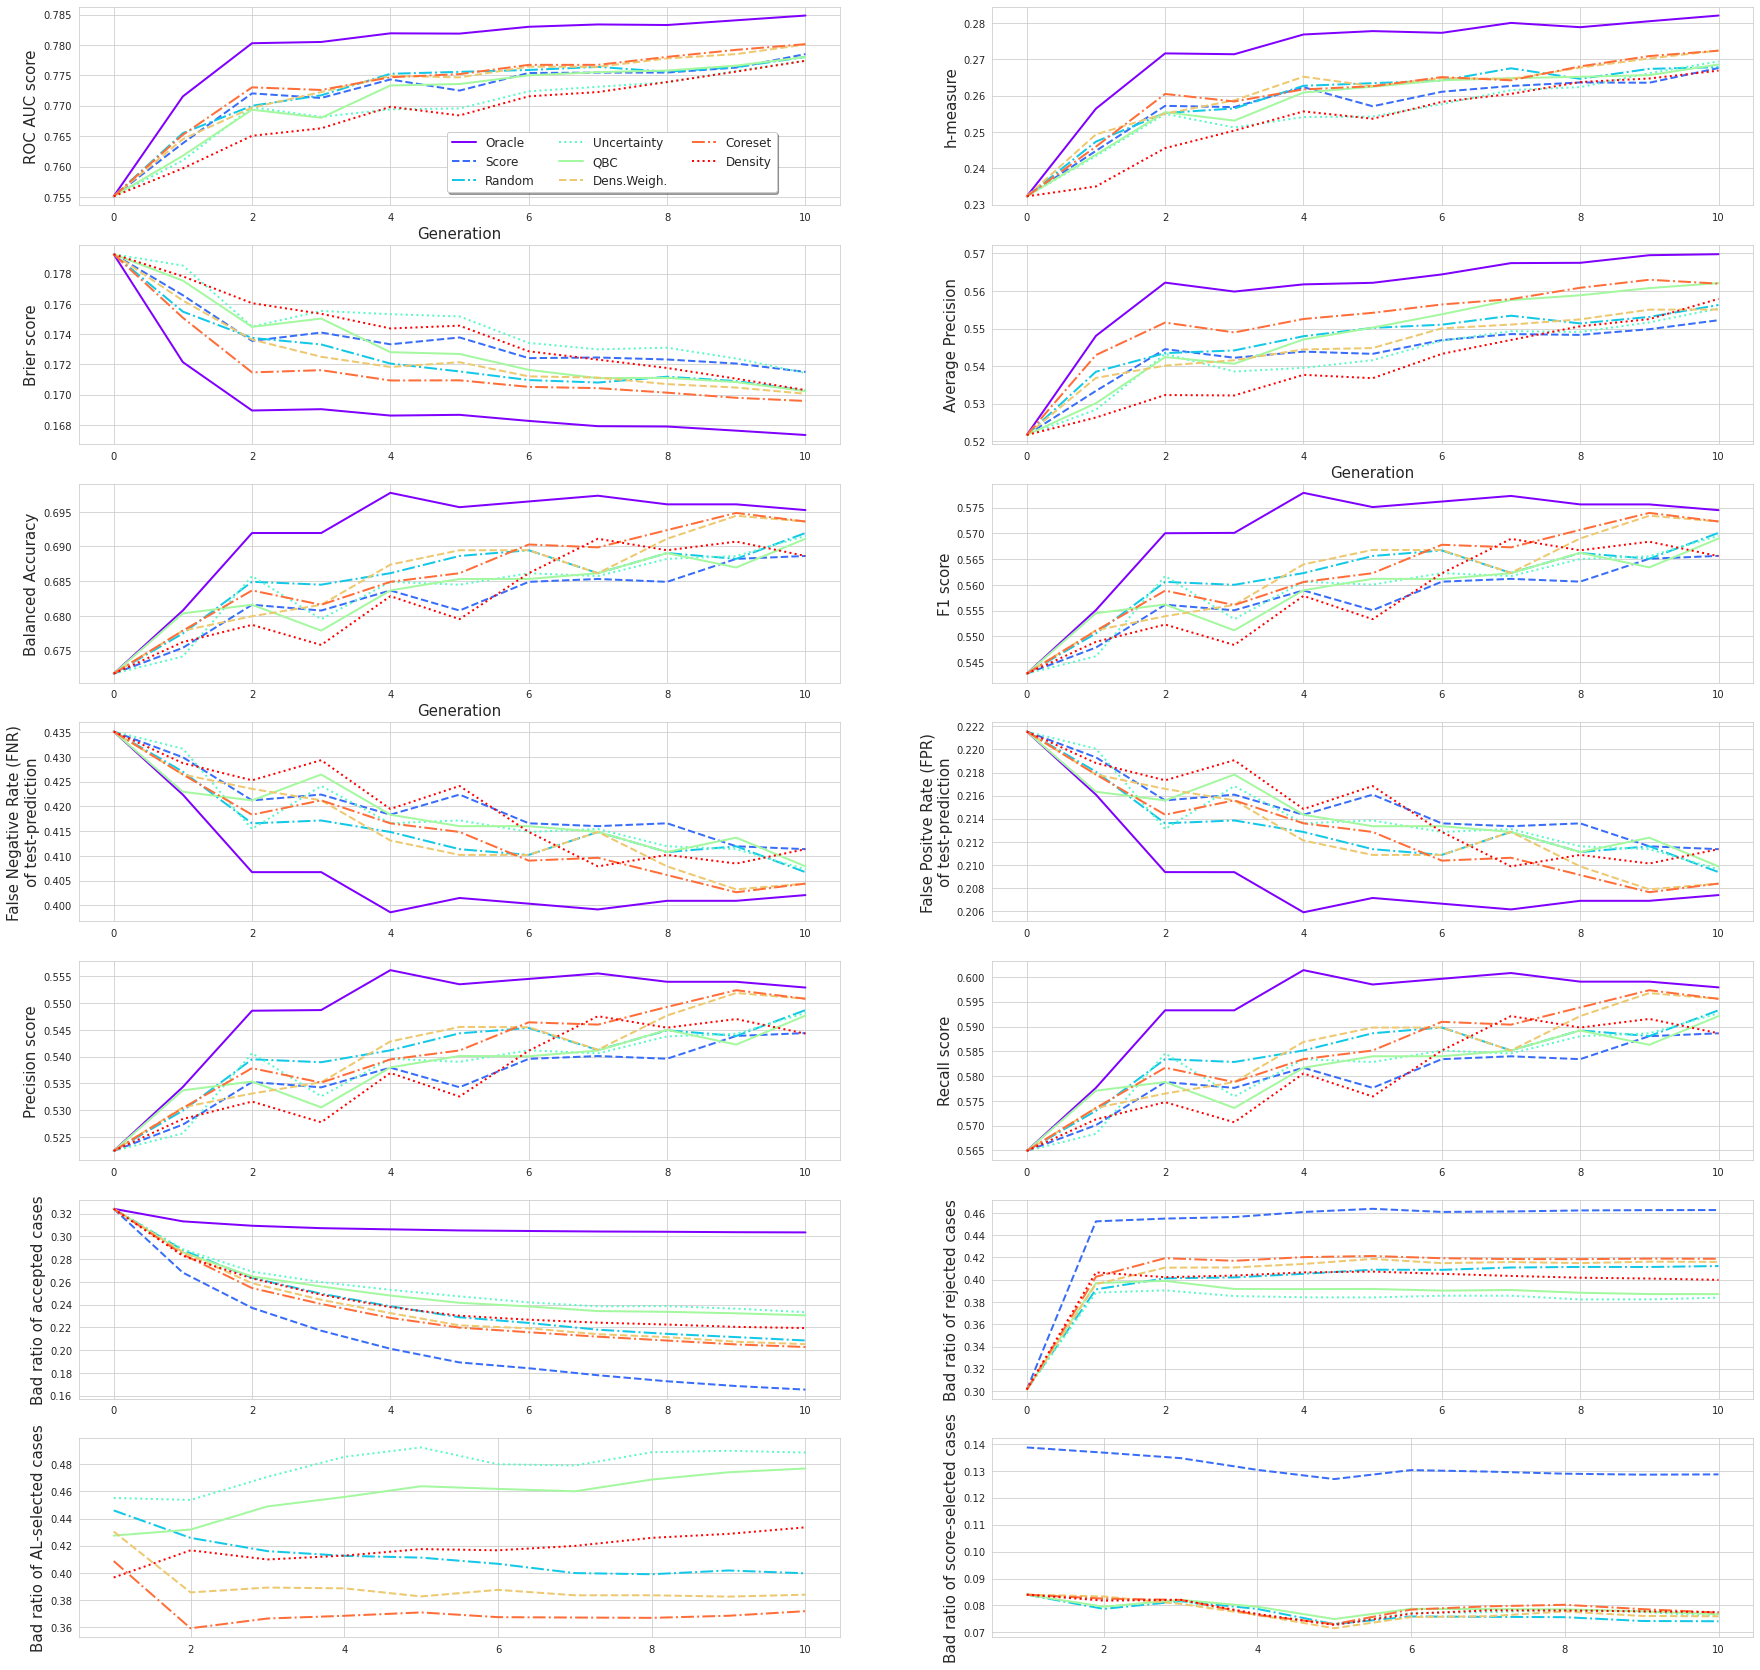

In [ ]:
############################################
# DEFINE LOOP THAT ITERATES OVER ALL AL MODELS
############################################

#### SET UP MODEL
classifier=LogisticRegression(solver="liblinear", penalty="l1", random_state=seed) 
#classifier=LogisticRegression(solver="lbfgs", penalty='l2', random_state=seed) #class_weight='balanced'
#classifier = LogisticRegression(solver = 'saga', penalty = 'elasticnet', l1_ratio = 1, random_state=seed)

### Training parameters
#path = None #path for saving model states and results, set none for no saving
testmode = True

#s_weights = False #sets higher sample weights of AL-selected instances
_I_have_installed_the_cvxpy = True #some AL models require cvxpy

tuned = True
param_dict = param_getter(tuned, dataset) # load tuned parameters

if tuned:
  for key in parma.keys():
    param_dict[key]['CLF']=param_dict['random']['CLF']


if testmode:  
  #test_ratio = 0.3 # not needed if Stratified-Kfold is used
  max_gens = 10 #per round (outer loop) this parameter sets the number of generations of applicants (inner loop)
  total_rounds = 5 #number of loop iterations, important for Stratified Kfold splitting of data
  init_ratio = 0.1
  init_size, sample_size  = split_sample_calc(X_model, init_ratio, total_rounds, max_gens)
  LOOP_params = {'rounds': total_rounds,
            'max_gens': max_gens,
            'init_sample': init_size, # init_sample: initial labaled sampel; is defined at the beginning
            #'test_ratio': test_ratio,
            'sample_size': sample_size, #1000 sample_size: number of applicants for each iteration
            'score_acc_rate': 0.5, # score_accept_rate: share OF APPLICANTS that are accepted by score
            'AL_acc_rate': 0.25, #0.125 AL_accept_rate: share OF APPLICANTS that are accepted by AL
            'weights': True, #sample weights
            'w_factor': 2,
            'scale': True,
            'do_threshold': 'mean', # either mean, roc or None
            'class_balance': False,  #balance class weights or not
            'tune_AL': True # setting false only has an effect on LAL
            #,'debug': False,            
            #,'cfs': False  #correlation based feature selection
            }


  AL_models = dict(
      oracle=['Oracle', 'Oracle'],
      score=['Score','Score'],
      random=['Random','QueryInstanceRandom'],
      unc=['Uncertainty','QueryInstanceUncertainty'],
      qbc=['QBC','QueryInstanceQBC'],
      dw=['Dens.Weigh.', 'QueryInstanceDensityWeighted'],
      cors=['Coreset','QueryInstanceCoresetGreedy'],
      density=['Density','QueryInstanceGraphDensity'],
      #eer
      #quire
      #bmdr=['BMDR','QueryInstanceBMDR'], #only if cvxpy installed
      #spal=['SPAL','QueryInstanceSPAL'] #only if cvxpy installed
      )
  


else:

  ### Training parameters
  test_ratio = 0.5
  max_gens = 10 #per round (outer loop) this parameter sets the number of generations of applicants (inner loop)
  init_sample = split_sample_calc(X, max_gens = max_gens, test_ratio = test_ratio) #100
  total_rounds = 5

  LOOP_params = {'total_rounds': total_rounds,
            'max_gens': max_gens,
            'init_sample': init_sample, # init_sample: initial labaled sampel; is defined at the beginning
            'test_ratio': 0.3,
            'sample_size': 1000, # sample_size: number of applicants for each iteration
            'score_acc_rate': 0.2, # score_accept_rate: share of applicants are that are accepted by SCORE
            'AL_acc_rate': 0.1, # AL_accept_rate: share of applicants are that are accepted by AL
            'seed': seed,
            'weights': s_weights,
            'w_factor': 2,
            'debug': False,
            'scale': True,            
            'tune_clf': True,
            'cfs': True
            }
          #'metric': 'roc_auc_score',  #'f1_score'
          

  AL_models = dict(
      oracle=['Oracle','Oracle'],
      score=['Score','Score'],
      random=['Random','QueryInstanceRandom'],
      unc=['Uncertainty','QueryInstanceUncertainty'],
      qbc=['QBC','QueryInstanceQBC'],
      eer=['EER','QueryExpectedErrorReduction'],           ### very slow
      dw=['Dens.Weigh.', 'QueryInstanceDensityWeighted'],
      cors=['Coreset','QueryInstanceCoresetGreedy'],
      quire=['QUIRE','QueryInstanceQUIRE'],                 ### slow, no batch mode, samples need to be picked one by one with a for-loop
      density=['Density','QueryInstanceGraphDensity'],      ### rather slow
      lal=['LAL','QueryInstanceLAL']
      )  

  if _I_have_installed_the_cvxpy:
    AL_models['bmdr'] = ['BMDR','QueryInstanceBMDR']
    AL_models['spal'] = ['SPAL','QueryInstanceSPAL']
  
  

AL_stats={}
AL_indices={}
AL_cost={}

######################################
# generate Kfold data splits

skf = StratifiedKFold(n_splits=total_rounds, shuffle = True, random_state=seed)
idx = []
for train_index, test_index in skf.split(X_model, y_model):
  idx.append((train_index, test_index))

#print(np.shape(idx))

######################################
# run loop for all models, save results, create averages for all metrics (generation-wise averages over all rounds)
######################################


for key in AL_models:
  AL_stats["{}".format(key)] = {}
  AL_indices["{}".format(key)] = {}
  
  AL_cost["{}".format(key)] = {}
  AL_cost["{}".format(key)]['internal'] = {}
  AL_cost["{}".format(key)]['external'] = {}
  AL_cost["{}".format(key)]['total']= {} 

  if tuned == True:
    AL_params = param_dict[key]['AL']
    AL_params.pop('skip', None) #Baseline models oracle, random & score skip the sampler-step in the CV loop and only tune the clf. skip parameter is not needed here
    AL_params.pop('with_scaling', None) #Baseline models oracle, random & score skip the sampler-step in the CV loop and only tune the clf. skip parameter is not needed here
    CLF_params=param_dict['random']['CLF']
  
  else:
    AL_params = param_dict[key]
    CLF_params={'random_state': seed}
  
  for rnd in range(total_rounds):
    stats, indices, cost = AL_loop(data=X_model, 
                                   y=y_model, 
                                   indices=idx, 
                                   key = key,
                                   seed=seed, 
                                   classifier = classifier, 
                                   AL_models=AL_models, 
                                   iteration = rnd, 
                                   AL_params=AL_params, 
                                   CLF_params=CLF_params, 
                                   **LOOP_params)

    AL_stats["{}".format(key)][rnd] = copy.deepcopy(stats)
    AL_indices["{}".format(key)][rnd] = copy.deepcopy(indices)
    
    colnames = [i for i in iter(np.linspace(2, 30, 29))]
    '''AL_cost["{}".format(key)]['internal'][rnd] = pd.DataFrame(copy.deepcopy(cost['internal']), columns = colnames)
    AL_cost["{}".format(key)]['external'][rnd] = pd.DataFrame(copy.deepcopy(cost['external']), columns = colnames)
    AL_cost["{}".format(key)]['total'][rnd] = pd.DataFrame(copy.deepcopy(cost['total']), columns = colnames)'''

  AL_stats["{}".format(key)]['average'] = pd.concat(AL_stats["{}".format(key)]).groupby(level=1).mean()
  '''AL_cost["{}".format(key)]['internal']['average'] = pd.concat(AL_cost["{}".format(key)]['internal']).groupby(level=1).mean()
  AL_cost["{}".format(key)]['external']['average'] = pd.concat(AL_cost["{}".format(key)]['external']).groupby(level=1).mean()
  AL_cost["{}".format(key)]['total']['average'] = pd.concat(AL_cost["{}".format(key)]['total']).groupby(level=1).mean()'''


######################################
# print and save results
######################################

print(' \n \n ################################## \n ------------- RESULTS ------------- \n ################################## \n \n')
for key in AL_models:
  print("\n \n dataset {}: average results for strategy {}: \n \n".format(dataset, AL_models[key][0]), (AL_stats["{}".format(key)]["average"]), "\n \n \n")

#### save plots, results & indices
#filename = "{}_{}".format(dataset, re.sub("[\n]","",str(clf)).replace(" ", ""))
#filename = "{}_{}_tuned-{}".format(dataset, re.sub("[\n]","",str(clf)).replace(" ", ""), tuned)
filename = "{}_tuned-{}".format(dataset, tuned)
#filename = "{}_LR_tuned-{}".format(dataset, tuned)
for key in LOOP_params:
  if key not in ["debug"]:
    if LOOP_params[key] == False:
      filename += f"_{key}-F"
    elif LOOP_params[key] == True:
      filename += f"_{key}-T"
    else:
      filename += f"_{key}-{LOOP_params[key]}"

print(filename)

stats_plotter(AL_stats, AL_cost)
plt.savefig(f'result_images/{dataset}/{filename}.png', bbox_inches='tight')

a_file = open(f'model_results/{dataset}/{filename}', 'wb')
pickle.dump(AL_stats, a_file)
a_file.close()

'''b_file = open(f'model_indices/{dataset}/{filename}', 'wb')
pickle.dump(AL_indices, b_file)
b_file.close()

c_file = open(f'model_cost/{dataset}/{filename}', 'wb')
pickle.dump(AL_cost, c_file)
c_file.close()'''



In [ ]:
stats_plotter(AL_stats, AL_cost)

In [ ]:
param_dict = param_getter(True, dataset) # load tuned parameters
print(param_dict['random'])
param_dict['oracle']['CLF']={}
param_dict['oracle']['CLF']=param_dict['random']['CLF']
param_dict['score']['CLF']={}
param_dict['score']['CLF']=param_dict['random']['CLF']

{'AL': {'strategy_name': 'QueryInstanceRandom'}, 'CLF': {'tol': 1e-05, 'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 50, 'C': 1.0}}


In [ ]:
print(AL_stats['oracle']['average'])
print("\n \n", AL_stats['score']['average'])
print("\n \n", AL_stats['unc']['average'])

In [ ]:
 print(AL_cost['oracle']['total']['average'] - AL_cost['score']['total']['average'])

In [ ]:
print(1 - (AL_cost['unc']['total']['average'] / AL_cost['score']['total']['average']))

In [ ]:
AL_cost['unc']['external']['average']

# Save Results and Indices

In [ ]:
## Create Filename from training setup parameters

filename = "{}_{}_undersample-{}".format(dataset, re.sub("[\n]","",str(clf)).replace(" ", ""), do_undersample)
for key in params:
  if key not in ["debug"]:
    if params[key] == False:
      filename += f"_{key}-F"
    elif params[key] == True:
      filename += f"_{key}-T"
    else:
      filename += f"_{key}-{params[key]}"
print(filename)

In [ ]:
#### save plots and results
filename = "{}_clf-{}".format(dataset, re.sub("[\n]","",str(clf)).replace(" ", ""))
for key in params:
  filename += f"_{key}-{params[key]}"
print(filename)

a_file = open(f'RSLTS-{filename}', 'wb')
pickle.dump(AL_stats, a_file)
a_file.close()

a_file = open(f'IDX-{filename}', 'wb')
pickle.dump(AL_indices, a_file)
a_file.close()

stats_plotter(AL_stats)
plt.savefig(f'PLOTS-{filename}.png', bbox_inches='tight')


# Load results

In [ ]:
# LOAD PICKLED Results-Dictionary
filename = """gmsc_LogisticRegression(penalty='none',random_state=30)_u-sample-False_rounds-3_max_gens-10_init_sample-2500_test_ratio-0.3_sample_size-1000_score_acc_rate-0.25_AL_acc_rate-0.125_seed-30_weights-T_w_factor-2_cfs-F"""

infile = open(f'RSLTS-{filename}','rb')
AL_stats_load = pickle.load(infile)
infile.close()

In [ ]:
print(type(AL_stats_load['unc_stats']['average'].iloc[10,:]))


<class 'pandas.core.series.Series'>


In [ ]:
# PRINT RESULTS
for key in AL_models():
  for rnd in range(total_rounds):
    print("\n \n results for strategy {} round {}: \n \n".format(AL_models[key][0], rnd), (AL_stats["{}".format(key)][rnd]), "\n \n \n")
  print("\n \n average results for strategy {}: \n \n".format(AL_models[key][0]), (AL_stats["{}".format(key)]["average"]), "\n \n \n")

In [ ]:
# LOAD PICKLED Indices-Dictionary

filename = """gmsc_LogisticRegression(penalty='none',random_state=30)_u-sample-False_rounds-3_max_gens-10_init_sample-2500_test_ratio-0.3_sample_size-1000_score_acc_rate-0.25_AL_acc_rate-0.125_seed-30_weights-T_w_factor-2_cfs-F"""

infile = open(f'IDX-{filename}','rb')
AL_indices_load = pickle.load(infile)
infile.close()

In [ ]:
print(AL_indices_load['oracle_indices'])

{0: {'applicants_idx': {1: [72, 224, 346, 353, 375, 441, 672, 692, 839, 876, 890, 945, 1138, 1389, 1459, 1499, 1520, 1600, 1601, 1606, 1716, 1803, 1829, 1959, 1978, 2139, 2147, 2250, 2492, 2546, 2624, 3035, 3197, 3657, 4269, 4325, 4344, 4400, 4549, 4725, 4917, 4932, 4946, 5057, 5328, 5590, 5674, 5873, 6112, 6113, 6343, 6632, 6672, 6794, 6857, 6886, 6964, 7246, 7322, 7661, 7674, 7708, 7717, 7722, 8002, 8232, 8473, 9301, 9537, 9545, 9552, 9735, 9880, 10327, 10494, 10574, 10693, 10874, 11167, 11363, 11371, 11474, 11484, 11555, 11888, 11941, 12028, 12034, 12141, 12174, 12232, 12515, 12760, 12877, 12992, 13104, 13349, 13503, 13937, 13955, 14035, 14254, 14333, 14710, 15032, 15352, 15775, 16085, 16343, 16376, 16399, 16413, 16786, 16826, 16975, 17172, 17430, 18014, 18025, 18075, 18124, 18329, 18834, 18877, 18984, 19087, 19191, 19405, 19625, 19690, 19738, 19997, 20288, 20368, 20405, 20575, 20885, 20964, 20985, 21289, 21308, 21365, 21399, 21412, 21511, 21727, 21902, 21966, 22164, 22226, 22261, 2

In [ ]:
# PRINT INDICES

for key in ['score']:
  for rnd in AL_indices_load['{}'.format(key)].keys():
    for index in AL_indices_load["{}".format(key)][rnd].keys():
      for generation in AL_indices_load["{}".format(key)][rnd]['{}'.format(index)].keys():
        print("\n {} for strategy {} in generation {} of round {}: \n".format(
            index,AL_models[key][0],generation,rnd), 
            np.asarray(AL_indices_load["{}".format(key)][rnd]['{}'.format(index)][generation]),"\n")

# Print & Plot

In [ ]:
tot_cost

In [ ]:
print(AL_stats_load["score_stats"][0])

In [ ]:
fnr = AL_stats_load["score_stats"][0]["fn"]/(AL_stats_load["score_stats"][0]["fn"] + AL_stats_load["score_stats"][0]["tp"])
print(fnr)

fpr = AL_stats_load["score_stats"][0]["fp"]/(AL_stats_load["score_stats"][0]["tn"] + AL_stats_load["score_stats"][0]["fp"])
print(fpr)


#rownames = [i for i in AL_indices_load.keys()]
cnames = [str('factor_{}'.format(i)) for i in iter(np.linspace(2, 30, 29, dtype=int))]

########################################
# EXTERNAL COST
########################################

ext_cost = [fpr + fnr * i for i in iter(np.linspace(2, 30, 29))]
print(np.shape(ext_cost))
#np.stack(np.transpose(ext_cost))
ext_cost_df = pd.DataFrame(np.stack(np.transpose(ext_cost)), columns = cnames)
plt.figure()
ext_cost_df.transpose().plot()

print(ext_cost_df)

In [ ]:
np.linspace(2, 50, 25, dtype=int)

In [ ]:
# PRINT INDICES

for key in AL_models:
  for rnd in AL_indices['{}_indices'.format(key)].keys():
    for index in AL_indices["{}_indices".format(key)][rnd].keys():
      for generation in AL_indices["{}_indices".format(key)][rnd]['{}'.format(index)].keys():
        print("\n {} for strategy {} in generation {} of round {}: \n".format(
            index,AL_models[key][0],generation,rnd), 
            np.asarray(AL_indices["{}_indices".format(key)][rnd]['{}'.format(index)][generation]),"\n")

In [ ]:
for gen in [10,11]:
  print(np.asarray(AL_indices["score_indices"][0]["accept_idx"][gen][-1000:]), "\n\n\n\n\n\n")

In [ ]:
round10 = np.asarray(AL_indices["score_indices"][0]["accept_idx"][10])
round11 = np.asarray(AL_indices["score_indices"][0]["accept_idx"][12])


train_idx, test_idx, accept_idx, unlabel_idx = alibox.get_split(0)

#### DATA SCALER
# scale once for each round (not each generation within the round)
np.random.seed(seed)
scaler = MinMaxScaler()
scaler.fit(alibox._X[train_idx, :])
X_t = scaler.transform(np.array(alibox._X))

clf.fit(X_t[round10,:],alibox._y[round10])
pred10 = clf.predict_proba(X_t[test_idx, :])
print(len(round10), roc_auc_score(alibox._y[test_idx], pred10[:,1]))

clf.fit(X_t[round11,:],alibox._y[round11])
pred11 = clf.predict_proba(X_t[test_idx, :])
print(len(round11), roc_auc_score(alibox._y[test_idx], pred11[:,1]))

7500 0.8432423610486289
8999 0.5039039736333184


In [ ]:
AL_indices["score_indices"][0].keys()

dict_keys(['applicants_idx', 'score_accept_idx', 'score_reject_idx', 'gen_AL_select_idx', 'total_AL_select_idx', 'total_reject_idx', 'accept_idx'])

In [ ]:
print(np.asarray(AL_indices["unc_indices"][0]["gen_AL_select_idx"]))

{1: [346, 441, 839, 1600, 1978, 3657, 4725, 4932, 6964, 7246, 9545, 9552, 11888, 12992, 13104, 13503, 13955, 14710, 16343, 16975, 18984, 20405, 21308, 22226, 22393, 22850, 23161, 23401, 23872, 24788, 25575, 25852, 26585, 26984, 27353, 29361, 31275, 31329, 32796, 34598, 34851, 35223, 35453, 36083, 37943, 39290, 40082, 40288, 40471, 41224, 41363, 42199, 42368, 42468, 42806, 42891, 43014, 43171, 43561, 43709, 44409, 44573, 44890, 44926, 44960, 45277, 45699, 45702, 45890, 46024, 46082, 46405, 46441, 46697, 47044, 47695, 47852, 48577, 48673, 48913, 49164, 49357, 49731, 49949, 49955, 50385, 50469, 50701, 50888, 50906, 51367, 51385, 51671, 51739, 52216, 52292, 52309, 52417, 52507, 52569, 52935, 53389, 53556, 53561, 53750, 53919, 54044, 54270, 54388, 54509, 54793, 54858, 54921, 55191, 55306, 55458, 55556, 55635, 55759, 55945, 55963, 56525, 56826, 57282, 57508, 57927, 58100, 58184, 58467, 58573, 58579, 58808, 58916, 58981, 59039, 59090, 59389, 59512, 59603, 59775, 59861, 59885, 59925, 60060, 60

# Save Data and Plots

# CV Helper functions

In [ ]:
# get strategy

def strategy_getter(X, y, strategy_name="QueryInstanceRandom", train_idx = None, **kwargs):
    """Return the query strategy object from alipy package"""
    
    try:
        exec("from alipy.query_strategy import " + strategy_name)
    except:
        raise KeyError("Strategy " + strategy_name + " is not implemented in ALiPy.")
    strategy = None
    
    if train_idx is not None:
      strategy = eval(strategy_name + "(X=X, y=y, train_idx = train_idx, **kwargs)")
    else:
      strategy = eval(strategy_name + "(X=X, y=y, **kwargs)")
          
    # print(strategy)
    return strategy

In [ ]:

#####################################
def AL_resampler(X=None
              , y=None
              #, key # used to select correct strategy name from AL_Models
              , strategy_name = None
              , pass_index=False
              , model = None
              , skip = False
              #, strategy
              #, sample_size
              , **kwargs):

  # !TODO deal with score, orcle, random strategies, too >> they need to tune the CLF still...


  if skip:
    # for models such as oracle, score, random, no AL parameters need tuning. Hence a random selection of instances is passed to the classifier for training
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=seed) # THESE ARE POSITIONS, NOT INDICES    
    for label, unlabel in sss.split(X=X, y=y):
        label_idx, unlabel_idx = np.asarray(label), np.asarray(unlabel)    


  else:
    seed_everything(seed)

    n_instances = int(0.25 * len(X))

    t_idx = np.arange(len(X))

    if pass_index and not strategy_name == 'QueryInstanceLAL':
      strategy = strategy_getter(X, y, strategy_name, t_idx, **kwargs)

    elif not pass_index and not strategy_name == 'QueryInstanceLAL':
      strategy = strategy_getter(X, y, strategy_name, **kwargs)

    # special case because of extra RF; might be prohibitively expensive to tune
    elif strategy_name == 'QueryInstanceLAL':
      #provide a path for the generic training data, downloaded from https://github.com/ksenia-konyushkova/LAL/tree/master/lal%20datasets
      #otherwise the data will be downloaded in every iteration, which is costly in a CV loop
      #data_path = '/gdrive/My Drive/ACTIVE LEARNING THESIS/LAL_trainingdata/'
      #file_path = '/gdrive/My Drive/ACTIVE LEARNING THESIS/LAL_trainingdata/LAL-iterativetree-simulatedunbalanced-big.npz'
      
      param_dict = {**kwargs}
      reg_est=param_dict['reg_est']
      reg_depth=param_dict['reg_depth']
      reg_feat=param_dict['reg_feat']
      if reg_feat > np.shape(X)[1]:
        reg_feat = np.shape(X)[1]

      param_dict.pop('reg_est', None)
      param_dict.pop('reg_depth', None)
      param_dict.pop('reg_feat', None)

      strategy = strategy_getter(X, y, strategy_name = strategy_name, mode='LAL_iterative', train_slt=False, **param_dict)
      strategy.download_data()
      strategy.train_selector_from_file(reg_est=reg_est, reg_depth=reg_depth, feat=reg_feat)

      
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=seed) # THESE ARE POSITIONS, NOT INDICES    
    for label, unlabel in sss.split(X=X, y=y):
        label_idx, unlabel_idx = np.asarray(label), np.asarray(unlabel)
    
    '''print(np.max(label_idx))
    print(label_idx)
    print(np.max(unlabel_idx))
    print(unlabel_idx)'''

      
    if not model == None:
      model.fit(X[label_idx], y[label_idx])


    if strategy_name == 'QueryInstanceQUIRE': #strategy quire has no batch mode
      #select_idx = np.zeros(shape=n_instances, dtype=int) #empty array to be filled with selected indices
      label_idx = IndexCollection(label_idx)
      unlabel_idx = IndexCollection(unlabel_idx)

      '''print(label_idx[:10])
      print(np.shape(label_idx))'''

      print('starting selection')
      for n in range(n_instances):
        selection = strategy.select(label_index=label_idx.index, unlabel_index=unlabel_idx.index)[0] # returns a list of len one, hence the [0]
        #print('selection:', selection)
        #select_idx[n] = selection
        label_idx.update(selection)
        #print(label_idx[-10:])
        unlabel_idx.difference_update(selection)
      label_idx = label_idx.index

    elif strategy_name == 'QueryInstanceBMDR':
      select_idx = strategy.select(label_idx, unlabel_idx, model=model,batch_size=n_instances, qp_solver = 'OSQP')
      label_idx = np.concatenate((label_idx, select_idx))

    elif model == None:
      select_idx = strategy.select(label_idx, unlabel_idx, batch_size=n_instances)
      label_idx = np.concatenate((label_idx, select_idx))
    
    elif not model ==None:
      select_idx = strategy.select(label_idx, unlabel_idx, model=model,batch_size=n_instances)
      label_idx = np.concatenate((label_idx, select_idx))


  return X[label_idx,:], y[label_idx]

# CV testrampe

## misc

In [ ]:
# not needed in 'real life', as I only need accept_idx from outer loop
# this just needed for testing
train_idx, test_idx, accept_idx, unlabel_idx = data_manipulate.split(X=X, y=y, test_ratio=0.2, initial_label_rate=0.17385, split_count=1, all_class=True, saving_path=None)

print(np.shape(accept_idx))
print(np.shape(test_idx))

np.random.seed(seed)
scaler = MinMaxScaler()
scaler.fit(X[accept_idx[0], :])
X_t = scaler.transform(np.array(X))


X_cv = X_t[accept_idx[0],:]
y_cv = y[accept_idx]
test_X_cv = X_t[test_idx[0],:]
test_y_cv = y[test_idx]

print(np.shape(X_cv))
print(np.shape(y_cv))
print(np.shape(test_X_cv))
print(np.shape(test_y_cv))


from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)
#X_cv_train, y_cv_splits = skf.split(X_cv, y_cv)
indices = []
for train_index, test_index in skf.split(X_cv, y_cv):
  #print("TRAIN:", train_index, "TEST:", test_index)
  indices.append((train_index, test_index))
  #X_cv_train, X_cv_test = X_cv[train_index], X_cv[test_index]
  #y_cv_train, y_cv_test = y_cv[train_index], y_cv[test_index]




(1, 1000)
(1, 1438)
(1000, 28)
(1000,)
(1438, 28)
(1438,)


In [ ]:
# custom cv used to isolate issues with different distance metrics in the graph density strategy

import traceback

for i in range(5):
  try:
    tx = X_cv[indices[i][0]]
    ty = y_cv[indices[i][0]]
    print(tx.dtype)
    #print(tx[:10])

    print(np.sum(indices[i][0]))
    print(np.shape(tx), np.shape(ty))
    X_debug, y_debug = AL_resampler(X=tx, y=ty, strategy_name = 'QueryInstanceGraphDensity', pass_index= True, metric='canberra')
    # numeric: braycurtis, cosine, correlation, canberra, 
    # bool: hamming, dice, jaccard, rogerstanimoto, kulsinski....
    # >> all metrics that work with "boolean vectors" seem to work, whereas some metrics used for numeric vectors do not
    # euclidean, cityblock, manhattan, mahalanobis, minkowski,chebyshev,... seemingly work sometimes, but in those cases they select suspicously in strict succession (with some gaps), which does not indicate that the most informative samples are chosen
    # chosen set: canberra, jaccard, cosine, hamming
    # https://docs.scipy.org/doc/scipy/reference/spatial.distance.html
  except AssertionError:
   print('AssertionError caught!')
   print(traceback.format_exc())
   continue

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=1) # THESE ARE POSITIONS, NOT INDICES
  
for label, unlabel in sss.split(X=X_cv, y=y_cv): #just splitting on y, hence X provided as zeros
    label_idx, unlabel_idx = np.asarray(label), np.asarray(unlabel)

t_idx = np.concatenate((label_idx, unlabel_idx))
print(np.shape(t_idx))
print(len(label_idx))
print(len(unlabel_idx))


(1000,)
500
500


In [ ]:
strategy_name = 'QueryInstanceGraphDensity'
strategy = strategy_getter(X, y, strategy_name, t_idx, metric = 'cityblock')
select_idx = strategy.select(label_idx, unlabel_idx, batch_size=250)
#label_idx = np.concatenate((label_idx, select_idx))
print(select_idx)
print(np.sum(select_idx))

In [ ]:
strategy_name = 'QueryInstanceGraphDensity'
strategy = strategy_getter(X, y, strategy_name, t_idx, metric = 'euclidean')
select_idx = strategy.select(label_idx, unlabel_idx, batch_size=250)
#label_idx = np.concatenate((label_idx, select_idx))
print(select_idx)
print(np.sum(select_idx))

[512, 513, 515, 520, 521, 11, 527, 16, 19, 21, 535, 536, 539, 540, 542, 37, 39, 40, 556, 49, 561, 565, 54, 55, 566, 570, 572, 64, 66, 67, 580, 71, 585, 75, 79, 591, 593, 80, 598, 600, 92, 94, 608, 97, 612, 100, 102, 103, 618, 619, 108, 622, 110, 112, 113, 625, 119, 120, 128, 640, 130, 131, 641, 135, 649, 138, 651, 652, 143, 144, 660, 152, 155, 669, 670, 162, 164, 166, 679, 681, 682, 170, 687, 689, 178, 177, 179, 181, 697, 185, 189, 703, 706, 195, 710, 711, 202, 715, 716, 719, 209, 724, 214, 727, 726, 217, 216, 220, 221, 735, 224, 740, 741, 232, 234, 747, 751, 752, 240, 753, 243, 244, 755, 246, 241, 249, 254, 766, 774, 262, 270, 275, 789, 277, 279, 792, 281, 283, 796, 285, 798, 288, 800, 292, 804, 297, 299, 812, 305, 306, 820, 821, 822, 309, 311, 826, 828, 837, 838, 841, 844, 333, 334, 336, 338, 339, 851, 854, 859, 861, 350, 351, 865, 355, 868, 870, 872, 873, 362, 361, 363, 875, 878, 370, 882, 372, 885, 886, 376, 378, 890, 380, 891, 895, 896, 384, 898, 900, 901, 902, 903, 904, 394, 398,

In [ ]:
strategy_name = 'QueryInstanceGraphDensity'
strategy = strategy_getter(X, y, strategy_name, t_idx, metric = 'cosine')
select_idx = strategy.select(label_idx, unlabel_idx, batch_size=250)
#label_idx = np.concatenate((label_idx, select_idx))
print(select_idx)
print(np.sum(select_idx))

[512, 513, 520, 521, 522, 11, 527, 16, 19, 21, 536, 539, 540, 542, 37, 39, 40, 556, 49, 561, 565, 566, 55, 570, 572, 64, 66, 67, 71, 585, 75, 79, 591, 593, 80, 598, 600, 92, 94, 608, 612, 100, 102, 103, 105, 618, 619, 108, 622, 110, 112, 113, 625, 119, 120, 128, 640, 130, 131, 641, 135, 649, 138, 651, 652, 143, 660, 152, 155, 669, 670, 673, 162, 164, 166, 679, 681, 682, 170, 687, 689, 178, 177, 179, 181, 697, 185, 187, 188, 189, 703, 706, 195, 711, 202, 715, 716, 719, 209, 724, 214, 727, 726, 217, 215, 220, 221, 732, 224, 740, 741, 744, 232, 234, 747, 751, 752, 240, 753, 243, 244, 755, 246, 241, 249, 762, 254, 767, 774, 262, 270, 275, 789, 277, 279, 792, 281, 283, 796, 285, 798, 288, 800, 292, 804, 297, 299, 812, 305, 306, 820, 821, 822, 309, 311, 826, 828, 318, 837, 838, 839, 841, 844, 333, 334, 336, 338, 339, 851, 852, 854, 859, 861, 350, 351, 352, 865, 355, 868, 869, 870, 872, 873, 362, 361, 363, 878, 370, 882, 372, 885, 886, 376, 378, 890, 380, 891, 895, 896, 384, 898, 900, 901, 90

## actual CV

In [ ]:
# use imblearn pipeline to skip AL sampling process in the prediction phase
from imblearn.pipeline import Pipeline
from imblearn import FunctionSampler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
#from skopt import BayesSearchCV #not compatible with latest sklearn
#from skopt.space import Real, Categorical, Integer


#cv_transformer = AL_Transformer(X, y, 'unc', AL_models, accept_idx[0], params, sample_size=500)
#sampler = FunctionSampler(AL_resampler(), validate=False)
pipe = Pipeline(steps=[('sampler', FunctionSampler(func=AL_resampler)),    # this will trigger a call to __init__
                      ('clf', LogisticRegression(random_state=seed))])

#name = AL_models['density'][1]
key='lal'

model = LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=0.5)

cv_parameters = {'oracle': [{'strategy_name': 'Oracle', 'skip': True}]
                ,'score': [{'strategy_name': 'Score', 'skip': True}]
                ,'random': [{'strategy_name': 'QueryInstanceRandom', 'skip': True}] 
                  
                ,'unc': [{'strategy_name': 'QueryInstanceUncertainty', 'model': model, 'measure': m} for m in ['entropy', 'least_confident', 'margin', 'distance_to_boundary']]
                ,'qbc': [{'strategy_name': 'QueryInstanceQBC', 'model': model, 'method': 'query_by_bagging', 'disagreement': d} for d in ['vote_entropy', 'KL_divergence']]
                ,'eer': [{'strategy_name': 'QueryExpectedErrorReduction', 'model': model}] #slow, even without tuning >> maybe don't tune at all? See what the other tuning cycles choose as clf parameters?
                ,'dw': [{'strategy_name': 'QueryInstanceDensityWeighted', 'model': model, 'uncertainty_meansure': u , 'distance': d, 'beta': b} for u in ['least_confident', 'margin', 'entropy'] for d in ['cityblock', 'cosine', 'euclidean'] for b in [0.5, 1, 2]]
                ,'density':[{'strategy_name': 'QueryInstanceGraphDensity', 'pass_index': True, 'metric': m} for m in ['canberra', 'jaccard', 'cosine', 'hamming']]
                ,'cors' :  [{'strategy_name': 'QueryInstanceCoresetGreedy', 'pass_index': True, 'distance': d} for d in ['cityblock', 'cosine', 'euclidean']]
                ,'quire': [{'strategy_name': 'QueryInstanceQUIRE','pass_index': True, 'kernel': 'rbf', 'lambda': l, 'gamma': g} for g in [0.1, 1, 10] for l in [0.1, 1, 10]] #SLOOOOOOOOW, 40 mins at njobs = 1, cv = 2, n_iter = 25 >> extremely low spec tuning
                ,'bmdr': [{'strategy_name': 'QueryInstanceBMDR', 'kernel': 'rbf', 'beta': b, 'gamma': g, 'rho': r, 'gamma_ker': gk} for b in [100, 1000, 10000] for g in [0.01, 0.1, 1] for r in [0.1, 1, 10] for gk in [0.1, 1, 10]] # issues with the solver ECOS
                ,'spal': [{'strategy_name': 'QueryInstanceSPAL', 'kernel': 'rbf', 'mu': mu, 'gamma': g, 'rho': r, 'lambda_init': li, 'lambda_pace': lp, 'gamma_ker': gk} for mu in [0.01, 0.1, 1] for g in [0.01, 0.1, 1] for li in [0.01, 0.1, 1] for lp in [0.001, 0.01, 0.1] for r in [0.1, 1, 10] for gk in [0.1, 1, 10]]
                
                ,'lal': [{'strategy_name': 'QueryInstanceLAL', 'cls_est': cls_est, 'reg_est': reg_est, 'reg_depth': reg_depth, 'reg_feat': reg_feat} for cls_est in [16,32,64] for reg_est in [32,64,128] for reg_depth in [5,10,20] for reg_feat in [5,6,7]] # SLOOOW to tune
                }

param_grid={'clf__solver': ['saga'], 'clf__penalty': ['elasticnet'], 'clf__l1_ratio': np.linspace(0, 1, 6),'clf__C': [0.1, 1., 10.], 'clf__max_iter': [50, 100, 250],'sampler__kw_args': cv_parameters[key]} #for  x in [125, 250, 500, 600]
#grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, refit='recall', scoring=['roc_auc', 'recall'])
grid_search = RandomizedSearchCV(pipe, param_distributions=param_grid, n_iter = 25, cv=2, n_jobs=-1, verbose=5, error_score="raise",refit='roc_auc', scoring=['roc_auc', 'recall'])
#grid_search = BayesSearchCV(pipe, search_spaces=param_grid, cv = 5, n_iter = 100, n_points = 2, n_jobs = 5, random_state=seed)



In [ ]:
grid_search.fit(X_cv, y_cv)

Fitting 2 folds for each of 25 candidates, totalling 50 fits
Building lal regression model from ./LAL-iterativetree-simulatedunbalanced-big.npz
Done!
Oob score =  0.1953452504398343


RandomizedSearchCV(cv=2, error_score='raise',
                   estimator=Pipeline(steps=[('sampler',
                                              FunctionSampler(func=<function AL_resampler at 0x7f50aa88cdd0>)),
                                             ('clf',
                                              LogisticRegression(random_state=30))]),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'clf__C': [0.1, 1.0, 10.0],
                                        'clf__l1_ratio': array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
                                        'clf__max_iter': [50, 100, 250],
                                        'clf__penalty': ['ela...
                                                              'strategy_name': 'QueryInstanceLAL'},
                                                             {'cls_est': 32,
                                                              'reg_depth': 5,
                                                

In [ ]:
iter_data = np.load(os.path.join(data_path, 'LAL-iterativetree-simulatedunbalanced-big.npz'), allow_pickle=True)

In [ ]:
data_path = '/gdrive/My Drive/ACTIVE LEARNING THESIS/LAL_trainingdata/'
os.path.join(data_path, 'LAL-iterativetree-simulatedunbalanced-big.npz')

'/gdrive/My Drive/ACTIVE LEARNING THESIS/LAL_trainingdata/LAL-iterativetree-simulatedunbalanced-big.npz'

In [ ]:
strategy = strategy_getter(X_cv, y_cv, strategy_name = 'QueryInstanceLAL', mode='LAL_iterative', train_slt=False, cls_est=10)
strategy.download_data()
strategy.train_selector_from_file(reg_est=32, reg_depth=10, feat=6)

Building lal regression model from ./LAL-iterativetree-simulatedunbalanced-big.npz
Done!
Oob score =  0.18911370310546471


In [ ]:
print(grid_search.best_params_)
AL_params = copy.deepcopy(grid_search.best_params_['sampler__kw_args'])   #[i] for i in grid_search.best_params_['sampler__kw_args'] if i not in ['key', 'name', 'sample_size']]
AL_params.pop('pass_index', None)
AL_params.pop('model', None)
#CLF_params = [grid_search.best_params_[i] for i in grid_search.best_params_ if i != 'sampler__kw_args']
CLF_params = copy.deepcopy(grid_search.best_params_)
CLF_params.pop('sampler__kw_args', None)

print(AL_params)
#print(CLF_params)

for key in CLF_params.keys():
  new_key = re.sub('clf__', '', key)
  CLF_params[new_key] = CLF_params.pop(key)
print(CLF_params)


{'sampler__kw_args': {'strategy_name': 'QueryInstanceLAL', 'cls_est': 16, 'reg_est': 64, 'reg_depth': 10, 'reg_feat': 6}, 'clf__solver': 'saga', 'clf__penalty': 'elasticnet', 'clf__max_iter': 50, 'clf__l1_ratio': 0.8, 'clf__C': 1.0}
{'strategy_name': 'QueryInstanceLAL', 'cls_est': 16, 'reg_est': 64, 'reg_depth': 10, 'reg_feat': 6}
{'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 50, 'l1_ratio': 0.8, 'C': 1.0}


In [ ]:
#print(grid_search.best_estimator_.steps[1][1])
print(grid_search.best_estimator_.steps[0][1].kw_args)
print(grid_search.best_params_['sampler__kw_args'])

{'strategy_name': 'QueryInstanceLAL', 'cls_est': 16, 'reg_est': 64, 'reg_depth': 10, 'reg_feat': 6}
{'strategy_name': 'QueryInstanceLAL', 'cls_est': 16, 'reg_est': 64, 'reg_depth': 10, 'reg_feat': 6}


In [ ]:
print("Best parameters set found on development set:", "\n")
print(grid_search.best_params_)
print("Grid scores on development set:", "\n")
means_roc = grid_search.cv_results_['mean_test_roc_auc']
stds_roc = grid_search.cv_results_['std_test_roc_auc']
for means_roc, stds_roc, params in zip(means_roc, stds_roc, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (means_roc, stds_roc * 2, params))
    

'''means_rec = grid_search.cv_results_['mean_test_recall']
stds_rec = grid_search.cv_results_['std_test_recall']
for means_rec, stds_rec, params in zip(means_rec, stds_rec, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (means_rec, stds_rec * 2, params))'''

print("\n", "Detailed classification report:", "\n")
print("The model is trained on the full development set.", "\n")
print("The scores are computed on the full evaluation set.", "\n")
y_pred = grid_search.predict(test_X_cv)
print(classification_report(test_y_cv, y_pred))


Best parameters set found on development set: 

{'sampler__kw_args': {'strategy_name': 'QueryInstanceLAL', 'cls_est': 16, 'reg_est': 64, 'reg_depth': 10, 'reg_feat': 6}, 'clf__solver': 'saga', 'clf__penalty': 'elasticnet', 'clf__max_iter': 50, 'clf__l1_ratio': 0.8, 'clf__C': 1.0}
Grid scores on development set: 

0.695 (+/-0.012) for {'sampler__kw_args': {'strategy_name': 'QueryInstanceLAL', 'cls_est': 64, 'reg_est': 32, 'reg_depth': 20, 'reg_feat': 7}, 'clf__solver': 'saga', 'clf__penalty': 'elasticnet', 'clf__max_iter': 250, 'clf__l1_ratio': 0.8, 'clf__C': 1.0}
0.640 (+/-0.045) for {'sampler__kw_args': {'strategy_name': 'QueryInstanceLAL', 'cls_est': 64, 'reg_est': 32, 'reg_depth': 10, 'reg_feat': 6}, 'clf__solver': 'saga', 'clf__penalty': 'elasticnet', 'clf__max_iter': 250, 'clf__l1_ratio': 0.6000000000000001, 'clf__C': 0.1}
0.687 (+/-0.012) for {'sampler__kw_args': {'strategy_name': 'QueryInstanceLAL', 'cls_est': 64, 'reg_est': 128, 'reg_depth': 5, 'reg_feat': 7}, 'clf__solver': 's

In [ ]:
grid_search.cv_results_['mean_test_recall']

## cv snippet from AL_Loop

In [ ]:
##########################################
  # CV TUNING OF AL MODEL AND CLF
  ##########################################
  name = AL_models[key][1]
  
  if key not in ['oracle', 'score', 'rnd']:
    #name = AL_models[key][1]
    #al_idx = accept_idx.index
    pipe = Pipeline(steps=[('sampler', FunctionSampler(func=AL_resampler)), # Imblearn FuntionSampler wrapper lets us use any script as a data sampler, making tuning of AL models possible
                          ('clf', clf)])



    cv_parameters = {'oracle': [{'strategy_name': 'Oracle', 'skip': True}]
                    ,'score': [{'strategy_name': 'Score', 'skip': True}]
                    ,'random': [{'strategy_name': 'QueryInstanceRandom', 'skip': True}] 
                     
                    ,'unc': [{'strategy_name': 'QueryInstanceUncertainty', 'model': model, 'measure': m} for m in ['entropy', 'least_confident', 'margin', 'distance_to_boundary']]
                    ,'qbc': [{'strategy_name': 'QueryInstanceQBC', 'model': model, 'method': 'query_by_bagging', 'disagreement': d} for d in ['vote_entropy', 'KL_divergence']]
                    ,'eer': [{'strategy_name': 'QueryExpectedErrorReduction', 'model': model}] #slow, even without tuning >> maybe don't tune at all? See what the other tuning cycles choose as clf parameters?
                    ,'dw': [{'strategy_name': 'QueryInstanceDensityWeighted', 'model': model, 'uncertainty_meansure': u , 'distance': d, 'beta': b} for u in ['least_confident', 'margin', 'entropy'] for d in ['cityblock', 'cosine', 'euclidean'] for b in [0.5, 1, 2]]
                    ,'density':[{'strategy_name': 'QueryInstanceGraphDensity', 'pass_index': True, 'metric': m} for m in ['canberra', 'jaccard', 'cosine', 'hamming']]
                    ,'cors' :  [{'strategy_name': 'QueryInstanceCoresetGreedy', 'pass_index': True, 'distance': d} for d in ['cityblock', 'cosine', 'euclidean']]
                    ,'quire': [{'strategy_name': 'QueryInstanceQUIRE','pass_index': True, 'kernel': 'rbf', 'lambda': l, 'gamma': g} for g in [0.1, 1, 10] for l in [0.1, 1, 10]] #slow, 40 mins at njobs = 1, cv = 2, n_iter = 25 >> extremely low spec tuning
                    ,'bmdr': [{'strategy_name': 'QueryInstanceBMDR', 'kernel': 'rbf', 'beta': b, 'gamma': g, 'rho': r, 'gamma_ker': gk} for b in [100, 1000, 10000] for g in [0.01, 0.1, 1] for r in [0.1, 1, 10] for gk in [0.1, 1, 10]] # issues with the solver ECOS
                    ,'spal': [{'strategy_name': 'QueryInstanceSPAL', 'kernel': 'rbf', 'mu': mu, 'gamma': g, 'rho': r, 'lambda_init': li, 'lambda_pace': lp, 'gamma_ker': gk} for mu in [0.01, 0.1, 1] for g in [0.01, 0.1, 1] for li in [0.01, 0.1, 1] for lp in [0.001, 0.01, 0.1] for r in [0.1, 1, 10] for gk in [0.1, 1, 10]]
                    }


    #missing quire parameters: #kernel : {'linear', 'poly', 'rbf', callable}; degree : int, optional (default=3) >> Degree of the polynomial kernel function ('poly'); coef0 : float, optional (default=1.) >> Independent term in kernel function.

    kw_args = cv_parameters[key]

    param_grid={'clf__solver': ['saga'], 'clf__penalty': ['elasticnet'], 'clf__l1_ratio': np.linspace(0, 1, 11),'clf__C': [0.01, 0.1, 1., 10.], 'clf__max_iter': [50, 100, 500],'sampler__kw_args': kw_args} #kw_args is passed to the sampler step of the pipeline, where the AL model is fit and instances are selected
    #grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, refit='recall', scoring=['roc_auc', 'recall'])
    #grid_search = BayesSearchCV(pipe, param_grid=param_grid, cv = 5, n_iter = 100, n_points = 2, n_jobs = 5, random_state=seed)
    grid_search = RandomizedSearchCV(pipe, param_distributions=param_grid, n_iter=cv_tries, cv=cv_folds, n_jobs=-1, verbose=1, refit='roc_auc', scoring=['roc_auc', 'recall', 'f1'], random_state=seed)

    X_cv = X[accept_idx.index,:]
    y_cv = y[accept_idx.index]

    grid_search.fit(X_cv, y_cv)

    al_hyperparameters = copy.deepcopy(grid_search.best_params_['sampler__kw_args'])
    al_hyperparameters.pop('pass_index', None)
    al_hyperparameters.pop('model', None)
    al_hyperparameters.pop('skip', None)

    clf = grid_search.best_estimator_.steps[1][1] # get the best estimator, 
